In [5]:
from __future__ import print_function
import numpy as np
import pandas as pd
import h5py
import glob
import math
import os
import shutil
import time
from scipy import signal
from scipy.signal import butter, lfilter
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Dropout, Reshape 
from keras.layers import Bidirectional, BatchNormalization, ZeroPadding1D, Conv2DTranspose, LeakyReLU
from keras.models import Model
from keras import backend as K
from keras.optimizers import SGD, Adam    
from keras import regularizers 
#from keras.engine.topology import Layer, InputSpec
from tensorflow.keras.layers import Layer, InputSpec
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from keras.initializers import VarianceScaling 
from keras.callbacks import CSVLogger
from scipy.optimize import linear_sum_assignment as linear_assignment
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
import metrics
import metrics_traffic
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from scipy.signal import stft


# Load data

In [44]:
load_path = r'C:\Users\Administrator\Desktop\data\input for DEC/site1_input.npy'
npy_folder = r'C:\Users\Administrator\Desktop\data\input_segments_site_1'

x_train_data = np.load(load_path)
print(x_train_data.shape)  
image_filenames = sorted(
    [f for f in os.listdir(npy_folder) if f.endswith('.npy')],
    key=lambda x: int(x.split('_')[1].split('.')[0])  
)
for i in range(10):
    print(f"Image Filename: {image_filenames[i]}")

(879, 1024)
Image Filename: segment_2.npy
Image Filename: segment_8.npy
Image Filename: segment_11.npy
Image Filename: segment_12.npy
Image Filename: segment_20.npy
Image Filename: segment_22.npy
Image Filename: segment_28.npy
Image Filename: segment_30.npy
Image Filename: segment_34.npy
Image Filename: segment_35.npy


# Load stft data

In [11]:
# STFT Parameters
fs = 500.0        # Sampling frequency
nperseg = 128     # Length of each segment
noverlap = 112    # Overlap
nfft = 530        # Number of FFT points
max_freq = 60     # Maximum frequency to retain

stft_results = []
all_stft_values = []
stft_results_normalized = []

# Compute STFT for each sample
for signal in x:
    signal = signal.flatten() 
    # Compute STFT
    f, t, Zxx = stft(signal, fs=fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft)
    # Filter frequencies
    valid_indices = f <= max_freq
    f_valid = f[valid_indices]
    Zxx_valid = Zxx[valid_indices]
    stft_results.append(np.abs(Zxx_valid))  

stft_results = np.array(stft_results)
stft_results = stft_results[:, :, :64]
t = t[:64]

print("STFT Results shape:", stft_results.shape)
print("Time shape:", t.shape)
print("Frequency shape:", f_valid.shape)


STFT Results shape: (879, 64, 64)
Time shape: (64,)
Frequency shape: (64,)


# Plot raw seismic signal and stft results

C:\Users\Administrator\AppData\Local\Temp\ipykernel_14568\322459371.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(y_tick_labels)


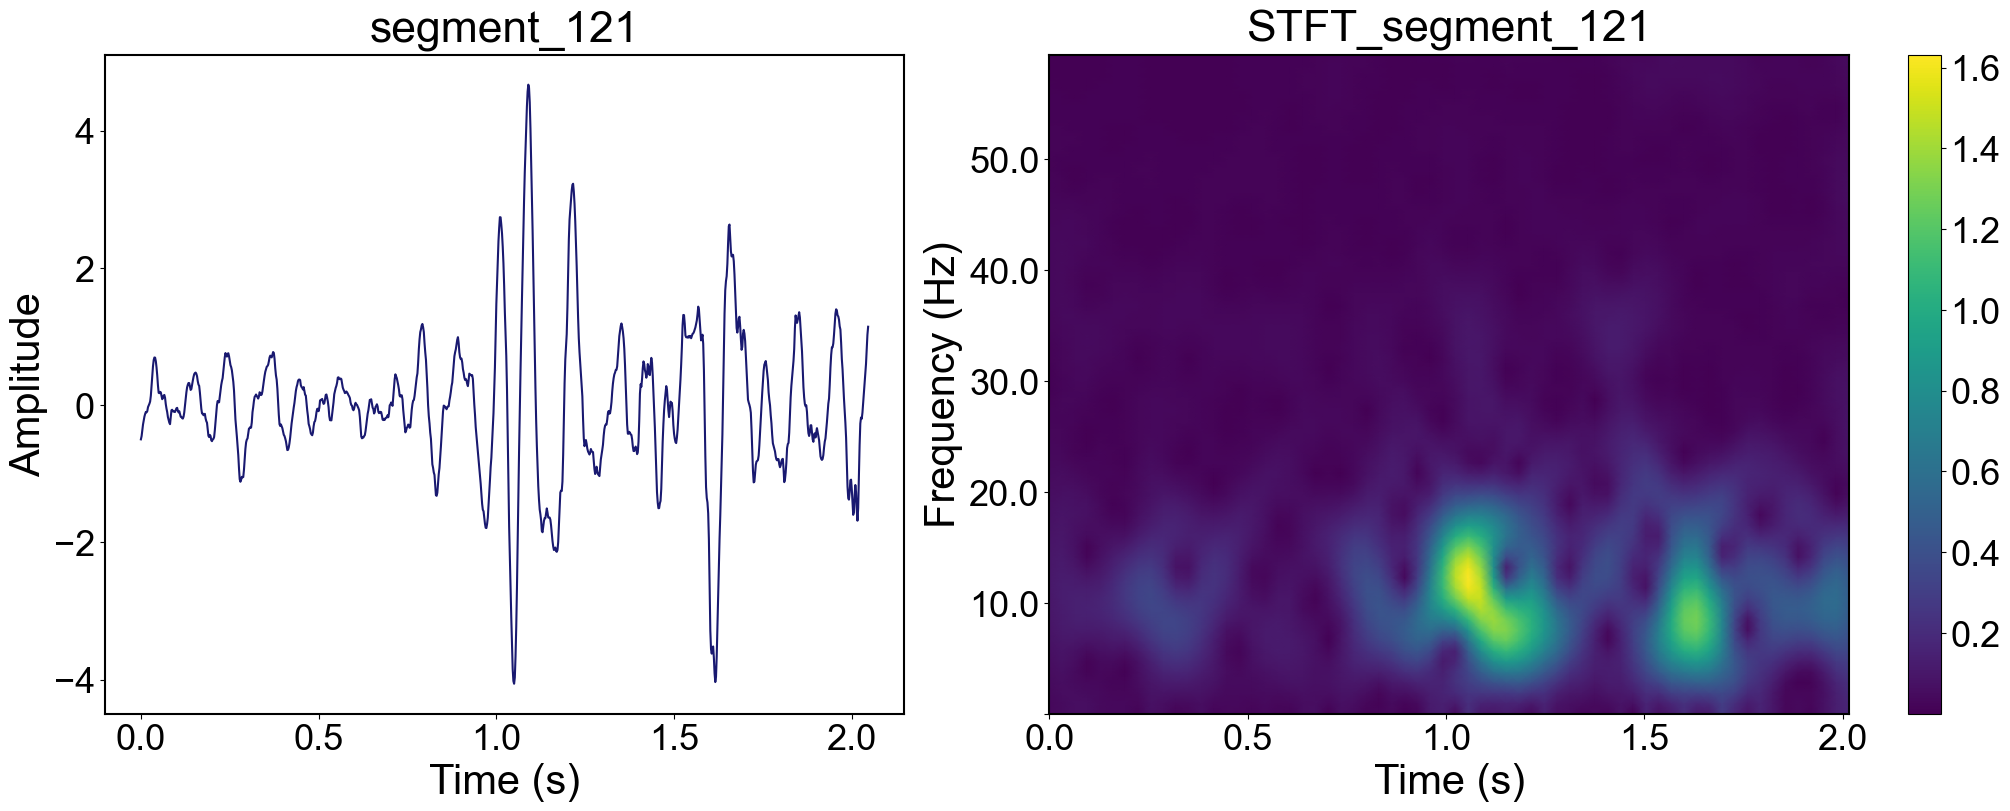

C:\Users\Administrator\AppData\Local\Temp\ipykernel_14568\322459371.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(y_tick_labels)


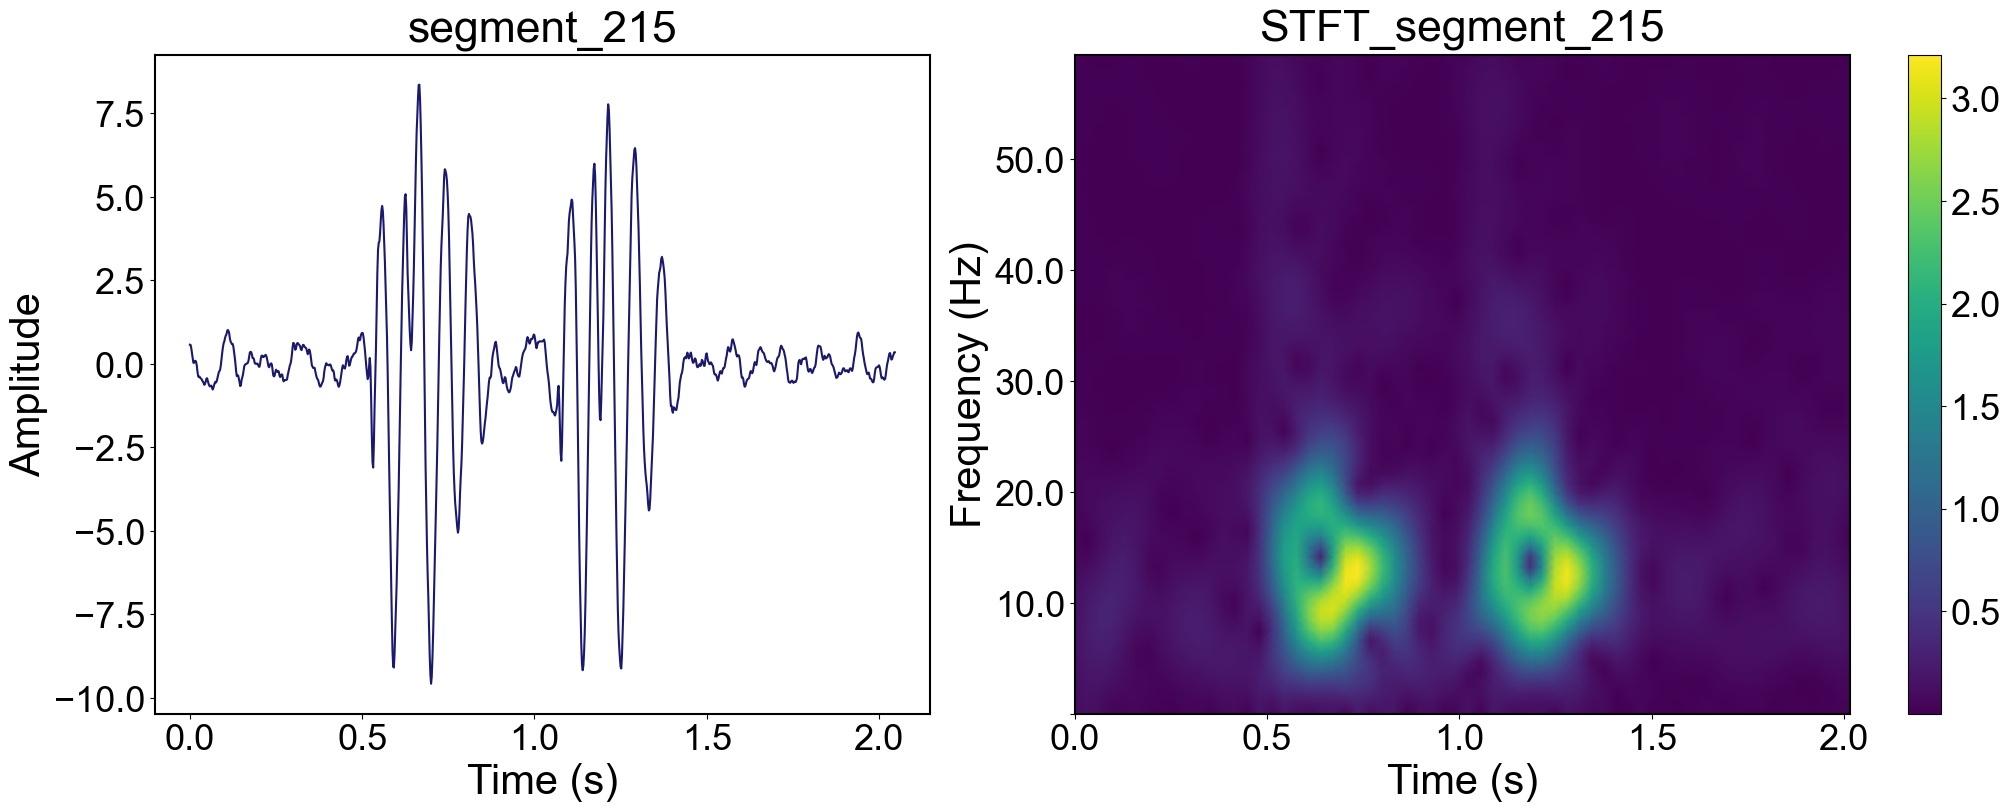

C:\Users\Administrator\AppData\Local\Temp\ipykernel_14568\322459371.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(y_tick_labels)


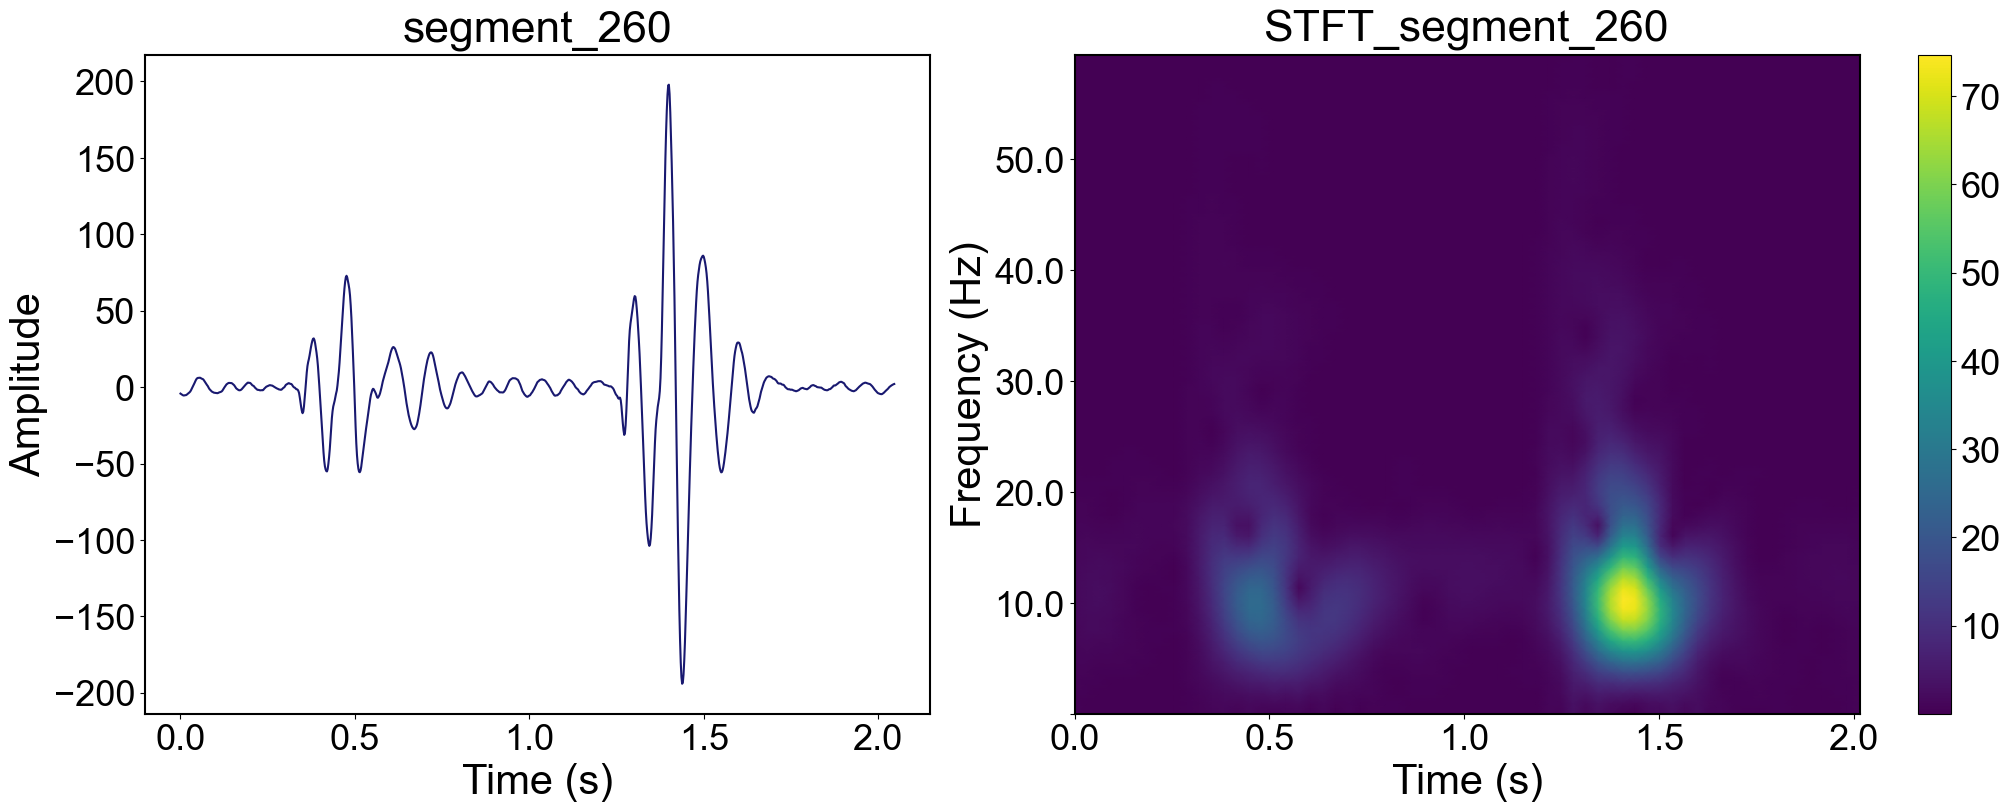

C:\Users\Administrator\AppData\Local\Temp\ipykernel_14568\322459371.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(y_tick_labels)


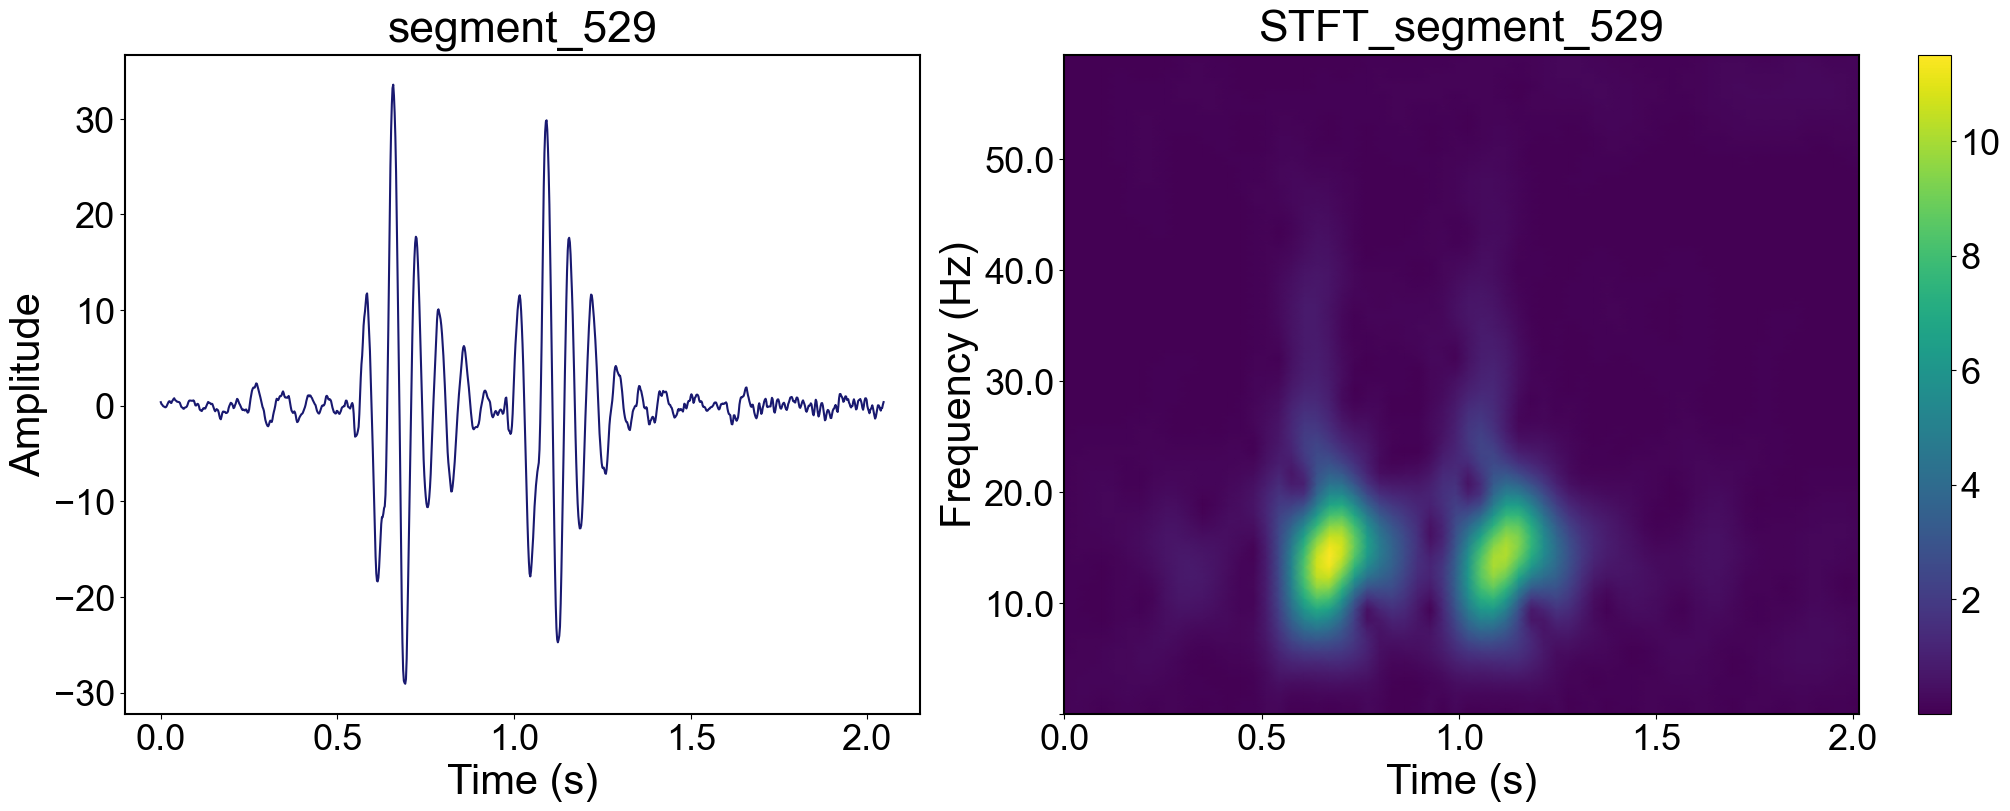

In [12]:
plt.rcParams['font.family'] = 'Arial'

dt = 0.002
signal_length = 2.048 
nn = math.floor(signal_length / dt)
time_axis = np.arange(0, nn) * dt

# indices_to_plot = np.array([401,402,403])
indices_to_plot = np.array([33,66,79,150])
indices_to_plot = indices_to_plot
for i in indices_to_plot:
# for i in range(20, 30):
    Zxx = stft_results[i]

    freq_bins = np.arange(Zxx.shape[0])  
    time_bins = np.arange(Zxx.shape[1]) 

    plt.figure(figsize=(20, 8), constrained_layout=True)
    plt.gcf().patch.set_linewidth(2)
    
    # Plot the raw waveform
    ax1 = plt.subplot(1, 2, 1)
    ax1.plot(time_axis, x[i], color='midnightblue')
    ax1.set_title(f'{image_filenames[i]}'.replace('.npy', ''), fontsize=32, pad=10)
    ax1.set_ylabel('Amplitude', fontsize=30)
    ax1.set_xlabel('Time (s)', fontsize=30)
    ax1.tick_params(axis='both', which='major', labelsize=26)
    ax1.grid(False)
    w = 1.5
    ax1.spines['top'].set_linewidth(w)
    ax1.spines['right'].set_linewidth(w)
    ax1.spines['bottom'].set_linewidth(w)
    ax1.spines['left'].set_linewidth(w)
    
    # Plot the Short-Time Fourier Transform (STFT)
    ax2 = plt.subplot(1, 2, 2)
    c = ax2.pcolormesh(t, f_valid, np.abs(Zxx), shading='gouraud', cmap='viridis')
    ax2.set_title('STFT_' + f'{image_filenames[i]}'.replace('.npy', ''), fontsize=32, pad=10)
    ax2.set_ylabel('Frequency (Hz)', fontsize=30)
    ax2.set_xlabel('Time (s)', fontsize=30)
    ax2.tick_params(axis='both', which='major', labelsize=26)
    ax2.spines['top'].set_linewidth(w)
    ax2.spines['right'].set_linewidth(w)
    ax2.spines['bottom'].set_linewidth(w)
    ax2.spines['left'].set_linewidth(w)
    y_ticks = ax2.get_yticks()
    y_tick_labels = [str(tick) if tick != 0 else '' for tick in y_ticks]
    ax2.set_yticklabels(y_tick_labels)

    colorbar = plt.colorbar(c, ax=ax2)
    colorbar.ax.tick_params(labelsize=26)
    
    # Save figure
    plt.savefig(os.path.join("plot/stft/field data", f'STFT_{image_filenames[i]}.png'))
    # plt.tight_layout()
    plt.show()
    plt.close()

# Input

In [13]:
x = np.abs(stft_results)
x.shape

(879, 64, 64)

# Building the autoencoder

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 64, 16)        160       
                                                                 
 batch_normalization_9 (Batc  (None, 64, 64, 16)       64        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 64, 64, 16)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 8)         

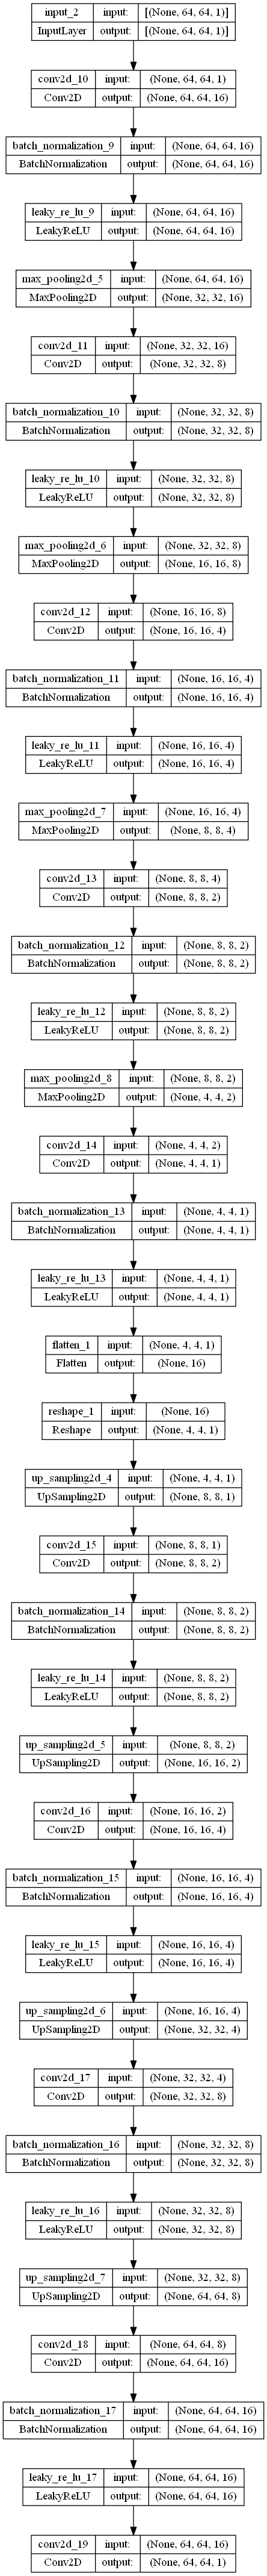

In [21]:
activation = 'relu'
kernel_initializer = 'glorot_uniform'

# Input layer
inp = Input(shape=(64, 64, 1))

# Encoder
e = Conv2D(16, (3, 3), padding='same', kernel_initializer=kernel_initializer)(inp)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
e = MaxPooling2D((2, 2), padding='same')(e)  # Output: (32, 32, 16)

e = Conv2D(8, (3, 3), padding='same', kernel_initializer=kernel_initializer)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
e = MaxPooling2D((2, 2), padding='same')(e)  # Output: (16, 16, 8)

e = Conv2D(4, (3, 3), padding='same', kernel_initializer=kernel_initializer)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
e = MaxPooling2D((2, 2), padding='same')(e)  # Output: (8, 8, 4)

e = Conv2D(2, (3, 3), padding='same', kernel_initializer=kernel_initializer)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
e = MaxPooling2D((2, 2), padding='same')(e)  # Output: (4, 4, 2)

e = Conv2D(1, (3, 3), padding='same', kernel_initializer=kernel_initializer)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
encoded = MaxPooling2D((2, 2), padding='same')(e)  # Output: (2, 2, 1)

# Flatten and reshape for decoding
shape_before_flattening = K.int_shape(e)
encoded = Flatten()(e)
d = Reshape(shape_before_flattening[1:])(encoded)

# Decoder
d = UpSampling2D((2, 2))(d)  # Output: (4, 4, 1)
d = Conv2D(2, (3, 3), padding='same', kernel_initializer=kernel_initializer)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)

d = UpSampling2D((2, 2))(d)  # Output: (8, 8, 2)
d = Conv2D(4, (3, 3), padding='same', kernel_initializer=kernel_initializer)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)

d = UpSampling2D((2, 2))(d)  # Output: (16, 16, 4)
d = Conv2D(8, (3, 3), padding='same', kernel_initializer=kernel_initializer)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)

d = UpSampling2D((2, 2))(d)  # Output: (32, 32, 8)
d = Conv2D(16, (3, 3), padding='same', kernel_initializer=kernel_initializer)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)

# Final output layer
decoded = Conv2D(1, (3, 3), padding='same')(d)  # Output: (64, 64, 1)

# Define the autoencoder and encoder models
autoencoder = Model(inputs=inp, outputs=decoded, name='autoencoder')
encoder = Model(inputs=inp, outputs=encoded, name='encoder')

# Print model summary
autoencoder.summary()

# Save and visualize the model architecture
from keras.utils import plot_model
architecture_fname = 'CAE_{}.png'.format('2025.01.02') 
plot_model(autoencoder, to_file=architecture_fname, show_shapes=True)
from IPython.display import Image
Image(filename=architecture_fname)

# Pretraining of the autoencoder

Epoch 1/500
28/28 [==============================] - 9s 81ms/step - loss: 1.3964
Epoch 2/500
28/28 [==============================] - 2s 54ms/step - loss: 0.8624
Epoch 3/500
28/28 [==============================] - 2s 55ms/step - loss: 0.7622
Epoch 4/500
28/28 [==============================] - 1s 53ms/step - loss: 0.7820
Epoch 5/500
28/28 [==============================] - 2s 61ms/step - loss: 0.7097
Epoch 6/500
28/28 [==============================] - 1s 53ms/step - loss: 0.7168
Epoch 7/500
28/28 [==============================] - 2s 54ms/step - loss: 0.6752
Epoch 8/500
28/28 [==============================] - 2s 67ms/step - loss: 0.6572
Epoch 9/500
28/28 [==============================] - 2s 65ms/step - loss: 0.6660
Epoch 10/500
28/28 [==============================] - 1s 52ms/step - loss: 0.6512
Epoch 11/500
28/28 [==============================] - 2s 54ms/step - loss: 0.6407
Epoch 12/500
28/28 [==============================] - 2s 63ms/step - loss: 0.6570
Epoch 13/500
28/28 [=====

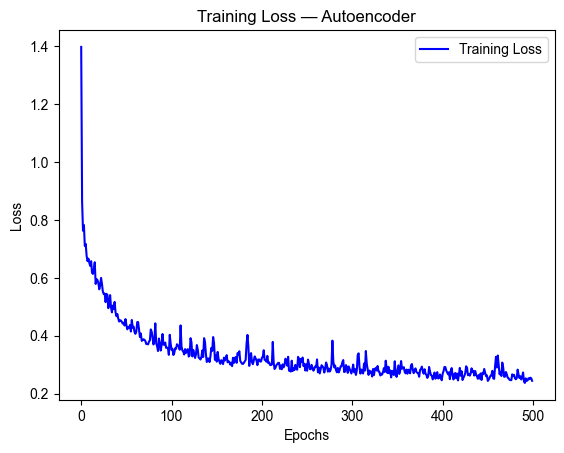

In [8]:
initial_learning_rate = 0.001
optimizer = Adam(learning_rate=initial_learning_rate)

# Compile the autoencoder with MSE loss
autoencoder.compile(optimizer=optimizer, loss='mse')
# Create CSV logger to record training history
csv_logger = CSVLogger('pretrain_log.csv')
# Train the model and retrieve training history
history = autoencoder.fit(x, x, batch_size=32, epochs=500, callbacks=[csv_logger])

# Plot the training loss curve
plt.plot(history.history['loss'], 'b', label='Training Loss')
plt.title('Training Loss — Autoencoder')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join("plot/stft/field data", "loss_curve.png"))
plt.show()

# save model

In [10]:
save_dir = 'model_field_data/'
encoder.save(os.path.join(save_dir,'encoder_model_site_1.h5'))
encoder.save_weights(os.path.join(save_dir,'en_weights_site_1.h5'))
autoencoder.save(os.path.join(save_dir,'autoencoder_model_site_1.h5'))
autoencoder.save_weights(os.path.join(save_dir,'ae_weights_site_1.h5'))

# load model

In [15]:
from tensorflow.keras.models import load_model

save_dir = 'model_field_data/'
autoencoder_model_path = os.path.join(save_dir, 'autoencoder_model_site_1.h5')
autoencoder = load_model(autoencoder_model_path)
autoencoder.summary()

encoder_model_path = os.path.join(save_dir, 'encoder_model_site_1.h5')
encoder = load_model(encoder_model_path)
encoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 64, 16)        160       
                                                                 
 batch_normalization_9 (Batc  (None, 64, 64, 16)       64        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 64, 64, 16)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 8)         

# Visualize inpout/reconstructed spectrograms and latent features

Processing index: 79


C:\Users\Administrator\AppData\Local\Temp\ipykernel_14568\4109394662.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_tick_labels)


1/1 [==============================] - 0s 141ms/step


C:\Users\Administrator\AppData\Local\Temp\ipykernel_14568\4109394662.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_tick_labels)


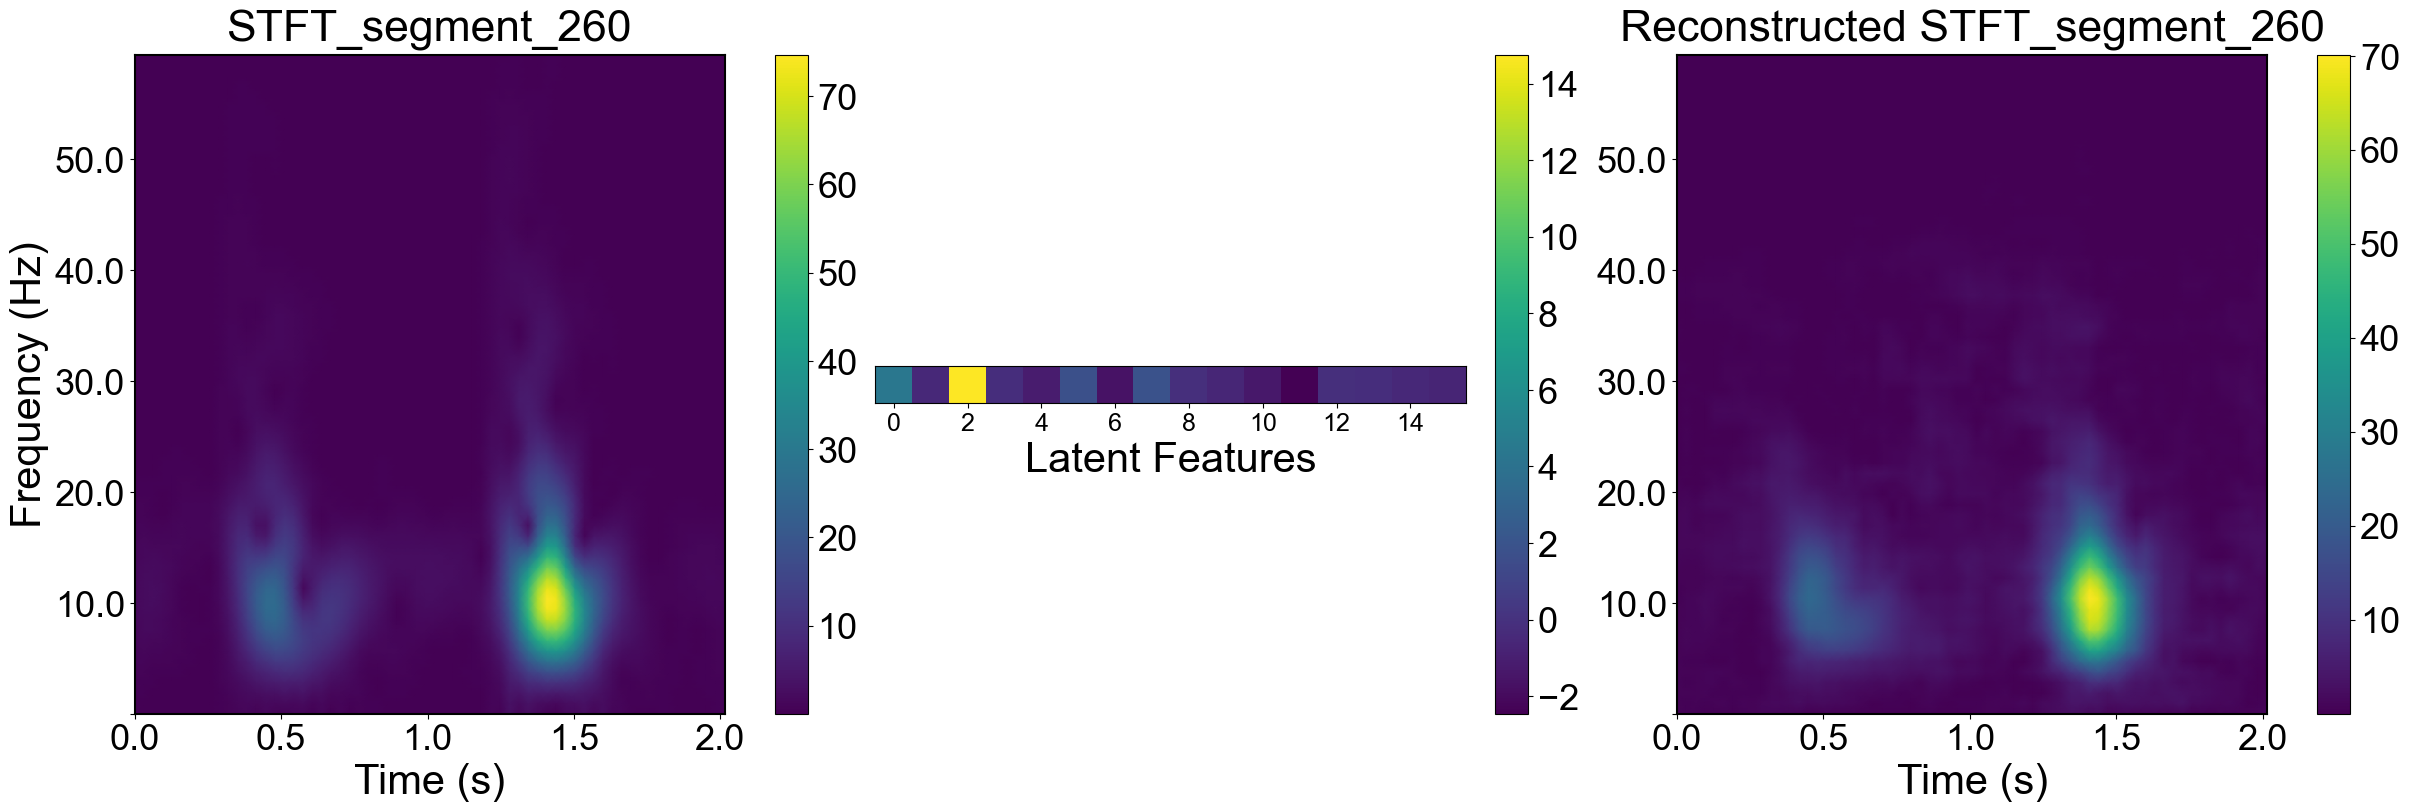

Processing index: 150
1/1 [==============================] - 0s 11ms/step


C:\Users\Administrator\AppData\Local\Temp\ipykernel_14568\4109394662.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_tick_labels)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_14568\4109394662.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_tick_labels)


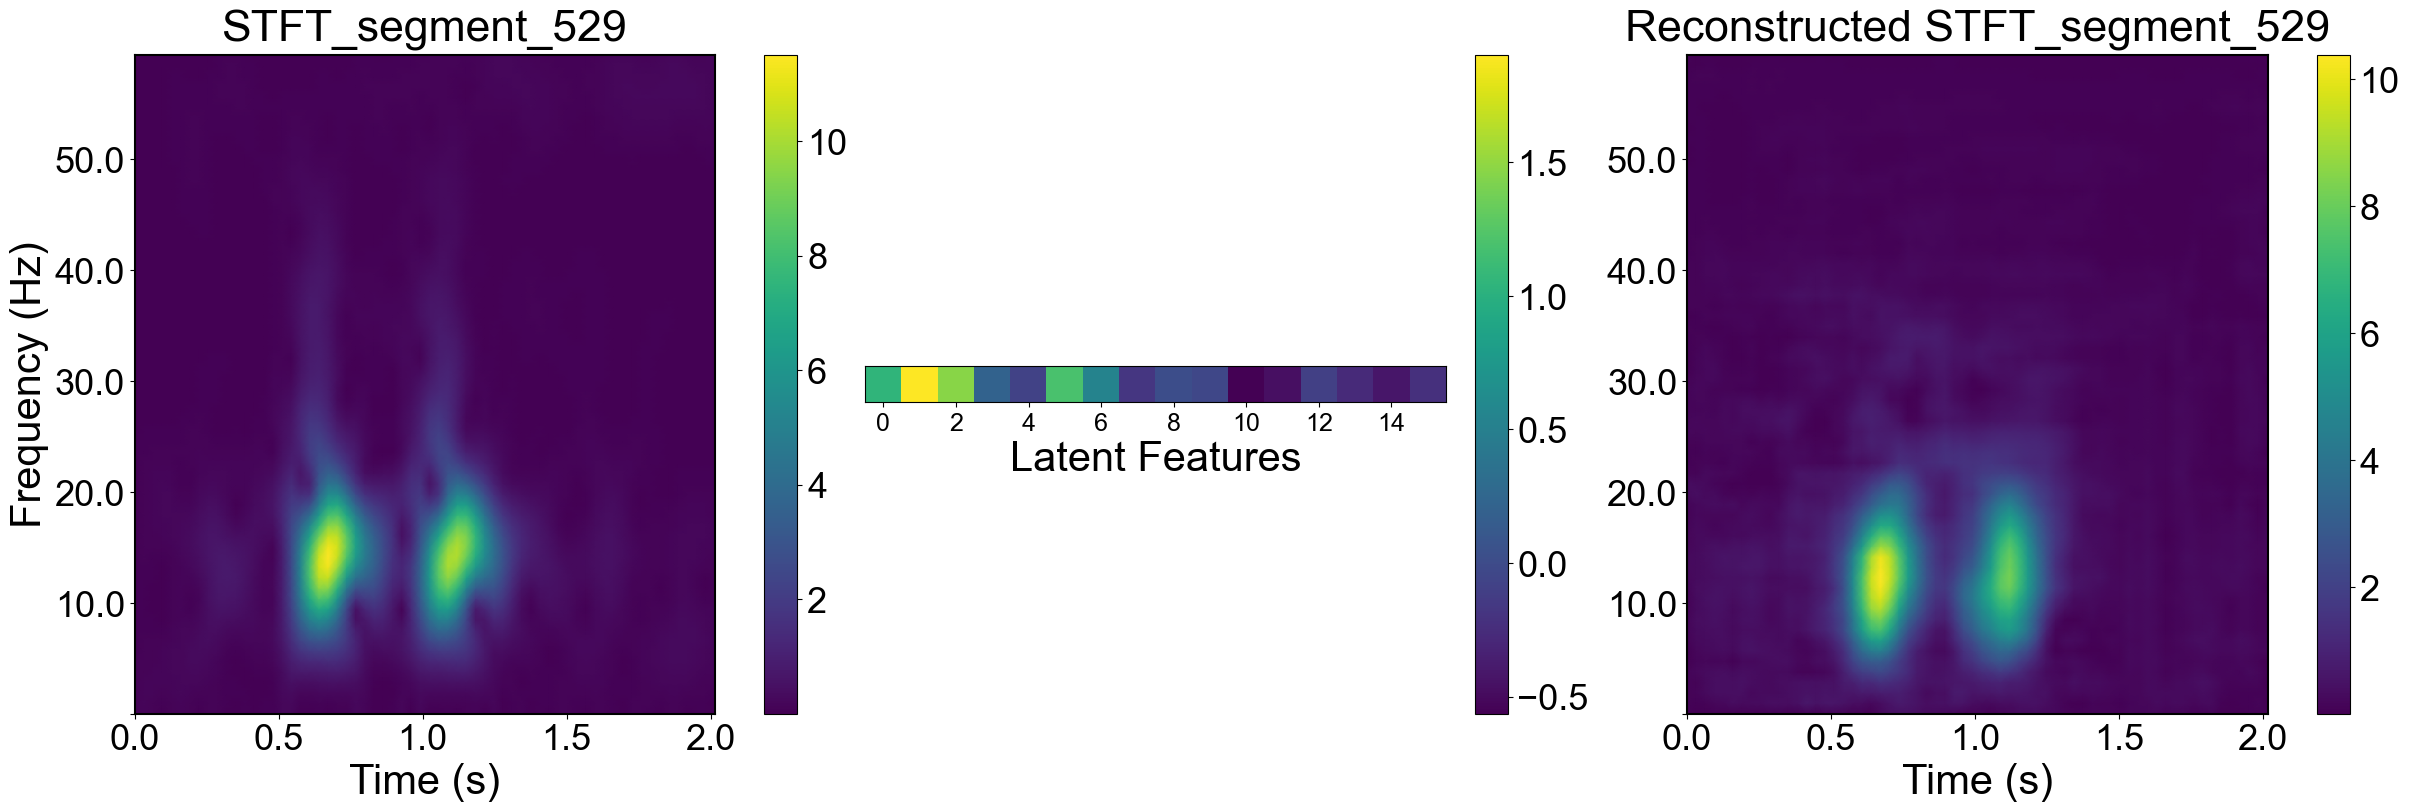

Processing index: 33
1/1 [==============================] - 0s 11ms/step


C:\Users\Administrator\AppData\Local\Temp\ipykernel_14568\4109394662.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_tick_labels)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_14568\4109394662.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_tick_labels)


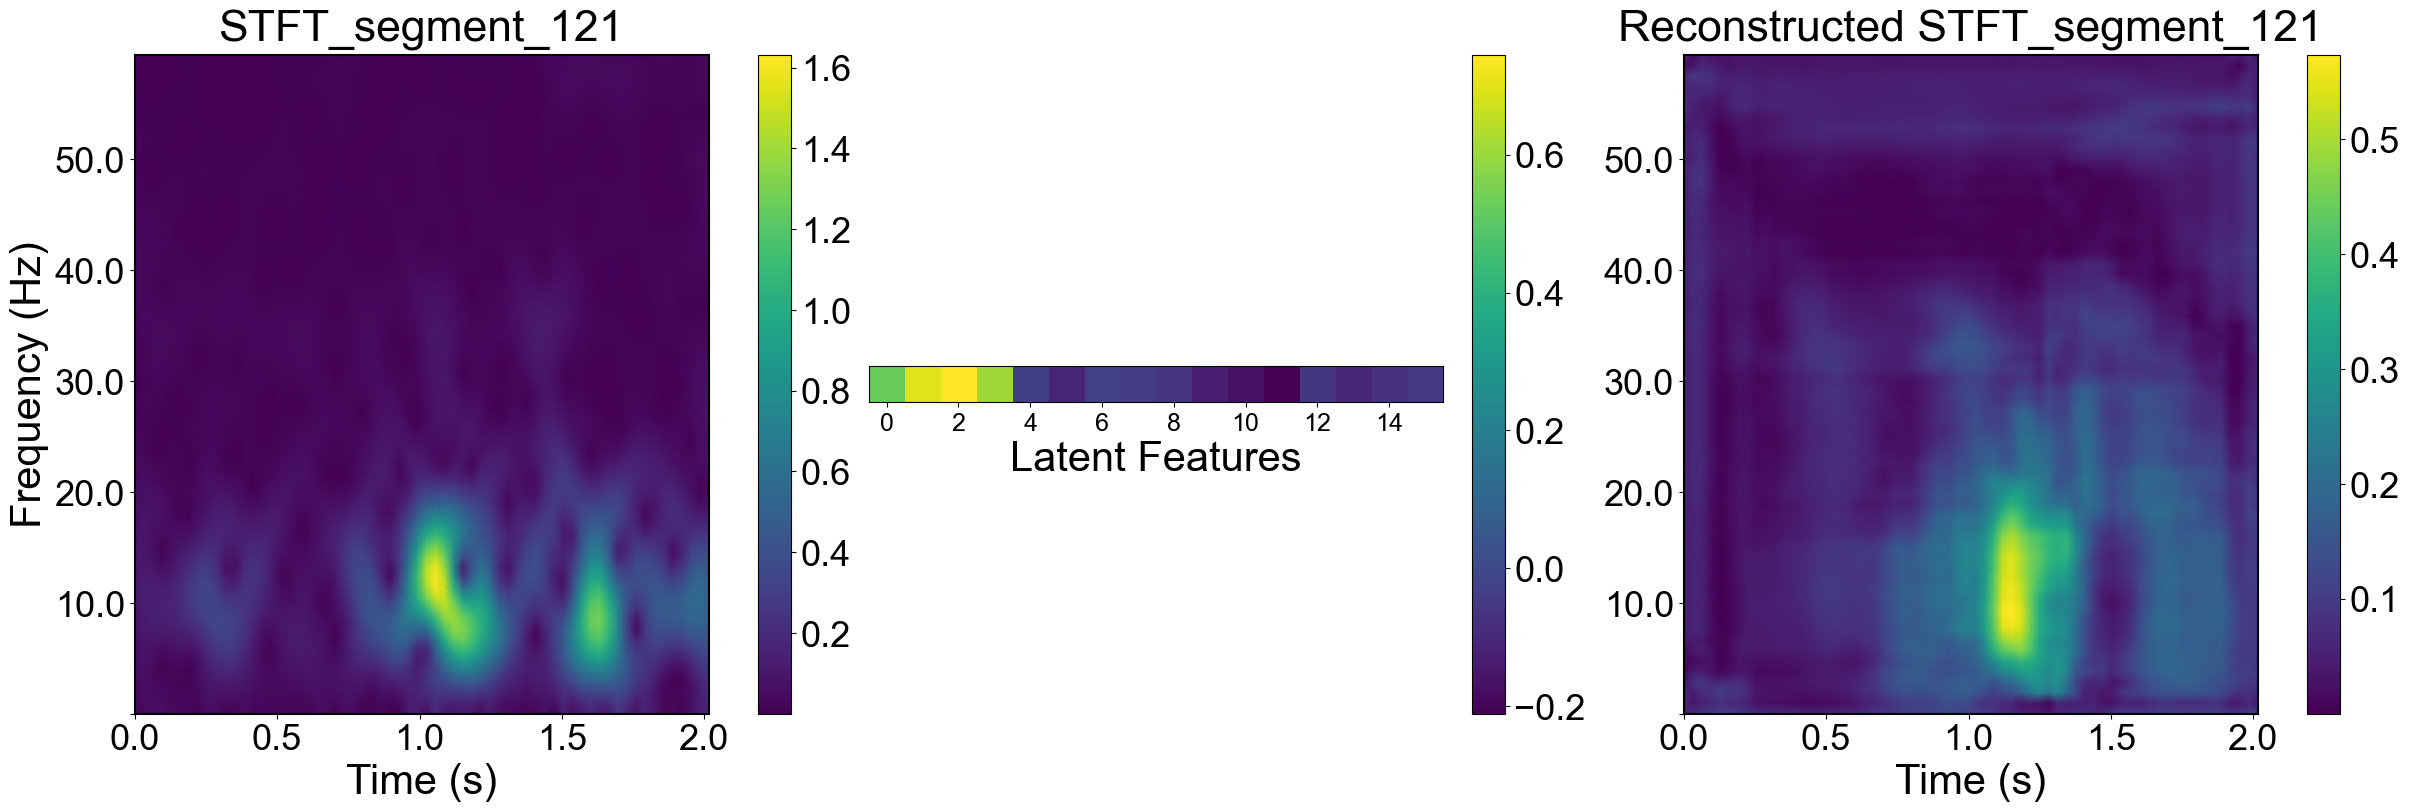

Processing index: 66
1/1 [==============================] - 0s 16ms/step


C:\Users\Administrator\AppData\Local\Temp\ipykernel_14568\4109394662.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_tick_labels)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_14568\4109394662.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_tick_labels)


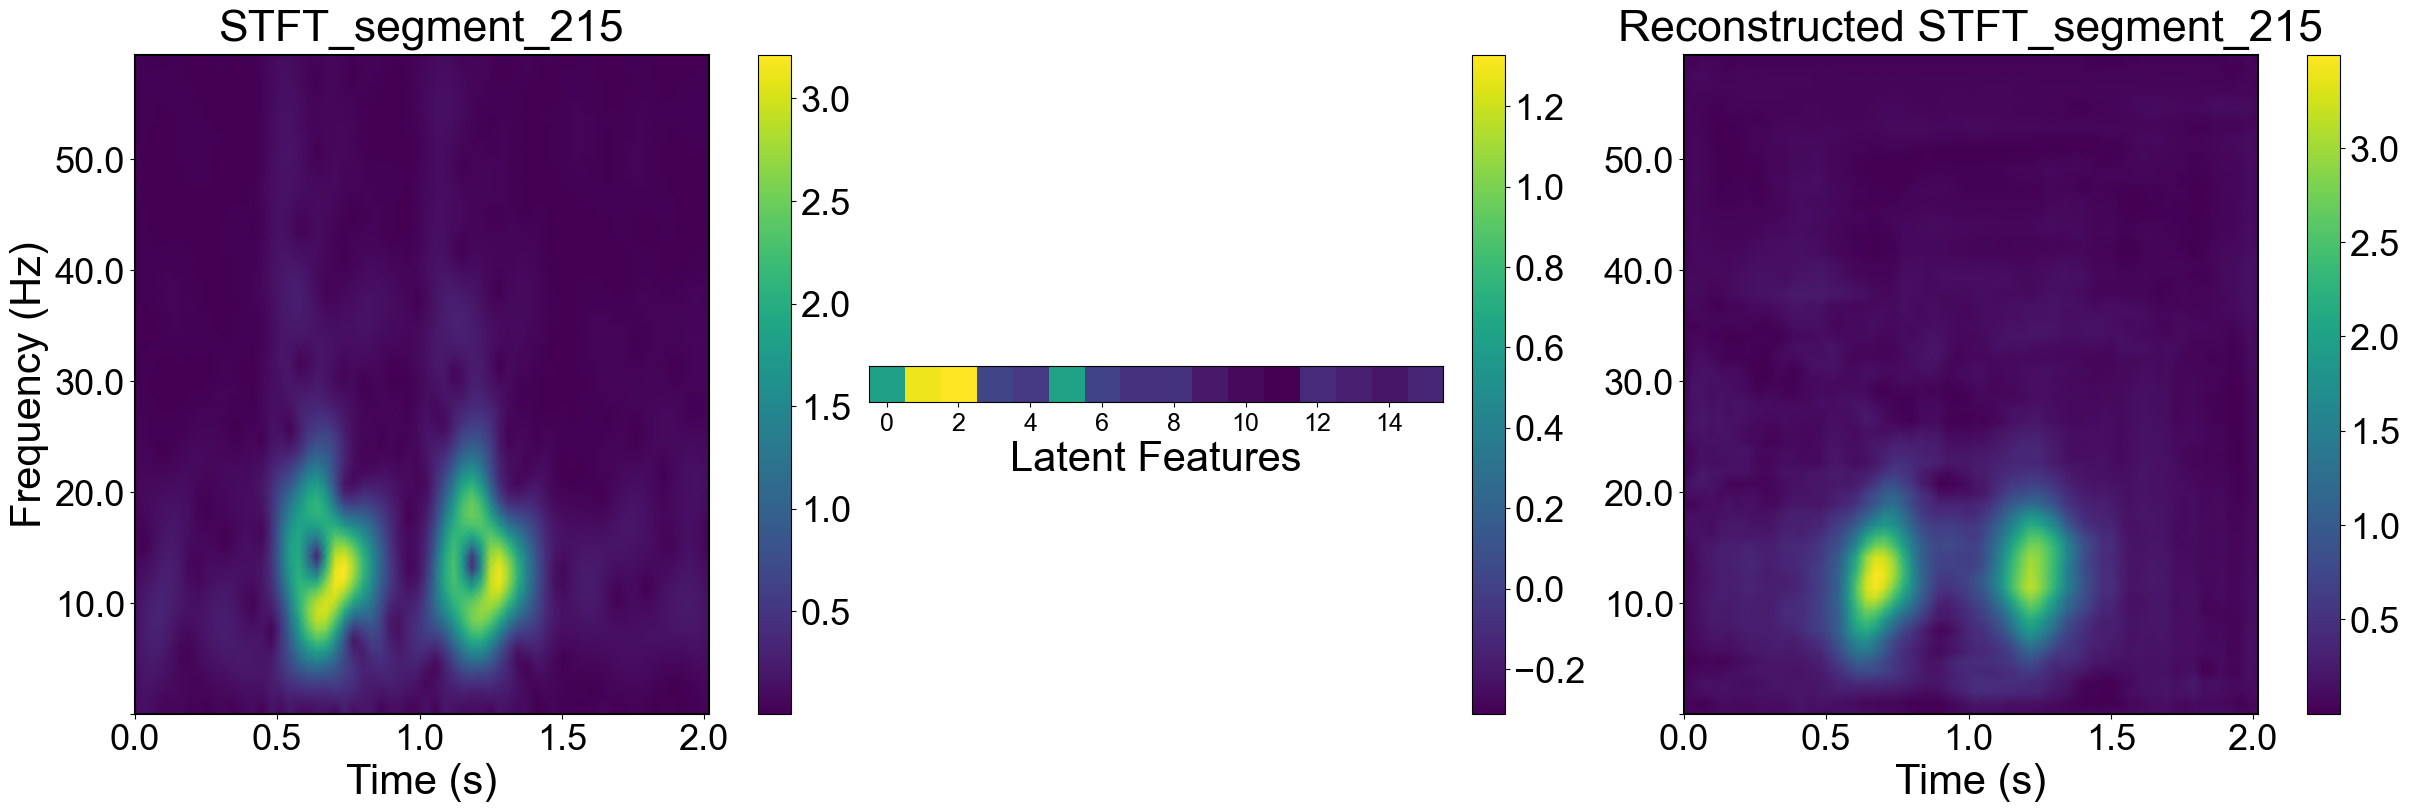

In [16]:
def plot_colorbar(c, ax):
    """Draw colorbar and set font size"""
    colorbar = plt.colorbar(c, ax=ax)
    colorbar.ax.tick_params(labelsize=26)

def plot_spectrogram(ax, signal, t, f_valid, title, xlabel, ylabel):
    """Plot spectrogram and apply formatting"""
    c = ax.pcolormesh(t, f_valid, np.abs(signal), shading='gouraud', cmap='viridis')
    ax.set_title(title, fontsize=32, pad=10)
    ax.set_xlabel(xlabel, fontsize=30)
    if ylabel:  
        ax.set_ylabel(ylabel, fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=26)
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    y_ticks = ax.get_yticks()
    y_tick_labels = [str(tick) if tick != 0 else '' for tick in y_ticks]
    ax.set_yticklabels(y_tick_labels)
    plot_colorbar(c, ax)


indices_to_plot = np.array([79, 150,33, 66])
for i in indices_to_plot:
    print(f"Processing index: {i}")

    fig = plt.figure(figsize=(24, 8), constrained_layout=True)
    
    # Subplot 1: Input spectrogram
    ax1 = fig.add_subplot(1, 3, 1)
    plot_spectrogram(ax1, x[i], t, f_valid, f'STFT_{image_filenames[i]}'.replace('.npy',''), 'Time (s)', 'Frequency (Hz)')
    
    # Subplot 2: Latent features
    encoded_features = encoder.predict(x[i:i+1])[0]
    ax2 = fig.add_subplot(1, 3, 2)
    ax2.imshow(encoded_features.reshape(1, 16), cmap='viridis')
    ax2.set_xlabel('Latent Features', fontsize=30)
    ax2.set_yticks(np.arange(0, 1, step=1)) 
    ax2.yaxis.set_tick_params(labelsize=16)
    ax2.set_yticks([]) 
    ax2.set_xticks(np.arange(0, 16, step=2))
    ax2.xaxis.set_tick_params(labelsize=18)
    plot_colorbar(ax2.images[0], ax2)

    # Subplot 3: Reconstructed spectrogram
    reconstructed_signal = autoencoder.predict(x[i:i+1])[0]
    ax3 = fig.add_subplot(1, 3, 3)
    plot_spectrogram(ax3, reconstructed_signal[:, :, 0], t, f_valid,
                     f'Reconstructed STFT_{image_filenames[i]}'.replace('.npy', ''),'Time (s)', ylabel=None)
    
    # plt.savefig(os.path.join("plot/stft/field data", f'recon_{image_filenames[i]}.png'))
    plt.show()

# Initialize KMeans clustering

In [17]:
n_clusters = 5

# Plotting Definitions
### These functions are used after clustering is completed. They provide a summary of cluster sizes and visualize representative waveform and spectrogram examples from each cluster.

In [18]:
def print_cluster_size_and_save_cluster_data(labels, save_path="plot/stft/field data/clusters"):
    """
    Print the number of samples in each cluster and save the indices of each cluster to separate text files.

    # Parameters
        labels: A 1D array of cluster assignment labels for each sample.
        save_path: Directory path to save the text files ("plot/stft/field data/clusters").
    
    # Output
        Prints the size of each cluster.
        Saves the sample indices of each cluster into a text file named as cluster_<label>.txt.
    """

    # Convert labels to NumPy array
    labels = np.array(labels)

    # Count unique cluster labels and their sample sizes
    unique_labels, counts = np.unique(labels, return_counts=True)
    print("Cluster Size Summary:")
    for label, count in zip(unique_labels, counts):
        print(f"Cluster {label}: {count} samples")
        cluster_indices = np.where(labels == label)[0]

        file_name = os.path.join(save_path, f"cluster_5_{label}.txt")
        with open(file_name, "w") as f:
            for idx in cluster_indices:
                f.write(f"{idx}\n")

    print(f"\nTotal Samples: {len(labels)}")
    print(f"\nCluster index files saved to folder: {save_path}")

In [19]:
from datetime import datetime

current_time = datetime.now().strftime("%Y%m%d_%H%M%S")  # Format: YYYYMMDD_HHMMSS

def print_all_clusters(data, labels, num_clusters, t, f_valid, x, time_axis, specified_indices_per_cluster=None):
    """
    Shows waveform data and spectrograms assigned to each cluster.
    - The first row of each cluster displays waveform data.
    - The second row displays the corresponding spectrogram.

    # Arguments
        data: Dataset (4D tensor) used as input for the clustering algorithm.
        labels: 1D array of clustering assignments. Each value corresponds to the cluster assigned to the respective sample in `data`.
        num_clusters: The number of clusters the data was separated into.
        t: Time axis for the spectrogram.
        f_valid: Frequency axis for the spectrogram.
        x: Original waveform data.
        time_axis: Time axis for waveform plotting.
        specified_indices_per_cluster: Dictionary specifying specific indices for each cluster. If None, the first 6 samples of each cluster are used.
    """

    save_dir = "plot/stft/field data"
    for cluster_num in range(num_clusters):
        label_idx = np.where(labels == cluster_num)[0]

        if len(label_idx) == 0:
            continue
        if specified_indices_per_cluster is not None and cluster_num in specified_indices_per_cluster:
            specified_indices = specified_indices_per_cluster[cluster_num]
            selected_indices = [label_idx[idx] for idx in specified_indices if 0 <= idx < len(label_idx)]
        else:
            selected_indices = label_idx[:6]  # use the first 6 samples in each cluster

        num_images = len(selected_indices)
        if num_images == 0:
            continue

        fig, axes = plt.subplots(2, 6, figsize=(24, 8))

        for i, idx in enumerate(selected_indices):
            # Plot waveform data (first row)
            ax1 = axes[0, i]
            ax1.plot(time_axis, x_train_data[idx], color='midnightblue')
            ax1.set_title(f'{image_filenames[idx]}', fontsize=10)
            ax1.set_ylabel('Amplitude', fontsize=10)
            ax1.set_xlabel('Time (s)', fontsize=10)
            ax1.tick_params(axis='both', which='major', labelsize=8)

            # Plot spectrogram (second row)
            Zxx = np.reshape(data[idx, :], (64, 64))  
            ax2 = axes[1, i]
            c = ax2.pcolormesh(t, f_valid, np.abs(Zxx), shading='gouraud', cmap='viridis')
            ax2.set_title(f'STFT of {image_filenames[idx]}', fontsize=10)
            ax2.set_ylabel('Frequency (Hz)', fontsize=10)
            ax2.set_xlabel('Time (s)', fontsize=10)
            ax2.tick_params(axis='both', which='major', labelsize=8)
            fig.colorbar(c, ax=ax2, fraction=0.046, pad=0.04)

        # Remove empty axes if less than 6 samples
        for j in range(num_images, 6):
            fig.delaxes(axes[0, j])
            fig.delaxes(axes[1, j])

        fig.suptitle(f'Cluster {cluster_num}', fontsize=16, ha='center')
        plt.tight_layout(rect=[0, 0, 1, 0.93])
        save_path = os.path.join(save_dir, f"cluster_{cluster_num}_{current_time}.png")
        plt.savefig(save_path)
        plt.show()

# add clustering layer into the bottelneck layer

...Finetuning...


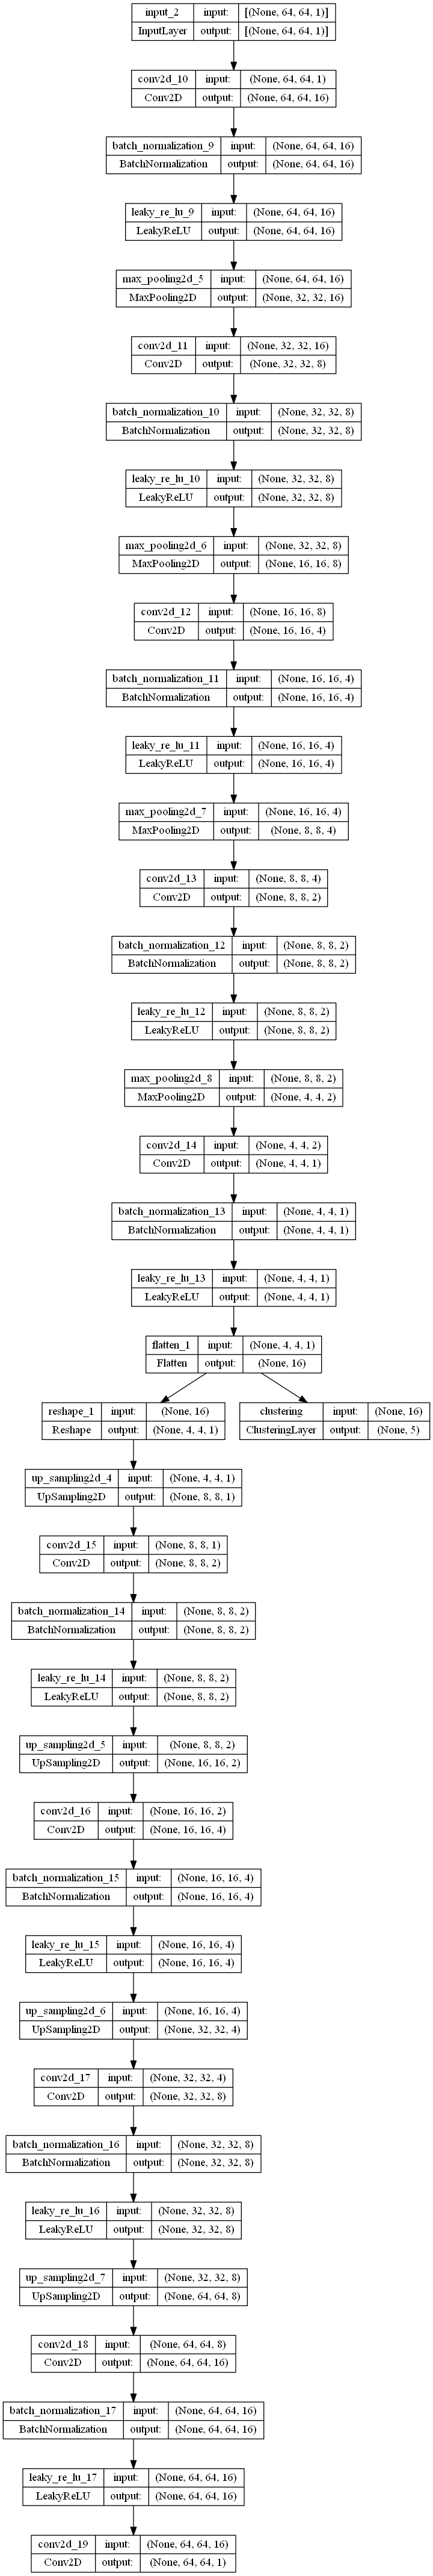

In [22]:
#### clustering layers
class ClusteringLayer(Layer):
    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        #self.clusters = self.add_weight((self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) 
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
print('...Finetuning...')   
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=[clustering_layer, autoencoder.output])
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer='adam')

from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png')

# Finetuning of full network

In [23]:
enc_train = encoder.predict(x, verbose=1)    # generate embedded latent space training samples

### initializing the weights using Kmean and assigning them to the model
#---------------------------------------------------------------------------------------------------------------------------
kmeans = KMeans(n_clusters=n_clusters, n_init=100) # run kmeans with n_clusters, run 100 initializations to ensure accuracy

labels = kmeans.fit_predict(enc_train)             # get initial assignments

labels_last = np.copy(labels)                      

# initialize the DEC clustering layer weights using cluster centers found initally by kmeans.                                                                         
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_]) 

28/28 [==============================] - 0s 2ms/step


D:\Anaconda\envs\kmeans\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [24]:
# Parameters for the  DEC finetuning
#--------------------------------------------------------------------------------------------------------------------
batch_size=32                     # number of samples in each batch
tol = 0.001                        # tolerance threshold to stop training
loss = 0                           # initialize loss
index = 0                          # initialize index to start 
maxiter = 1000                  # number of updates to rub before halting. (~12 epochs)
update_interval = 150              # Soft assignment distribution and target distributions updated evey 315 batches. 
                                   #(~12 updates/epoch)
index_array = np.arange(x.shape[0])

In [ ]:
###############################################################################
### simultaneous optimization and clustering
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

loss_list = np.zeros([maxiter,3])
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, reconst = model.predict(x, verbose=1)
        p = target_distribution(q)  # update the auxiliary target distribution p       
        y_pred = q.argmax(1) # evaluate the clustering performance

        # if y is not None:
        #     acc = np.round(metrics.acc(y, y_pred), 5)
        #     loss = np.round(loss, 5)
        #     print('Iter %d: acc = %.5f' % (ite, acc), ' ; loss=', loss)

        # check stop criterion
        delta_label = np.sum(labels != labels_last).astype(np.float32) / labels.shape[0]
        labels_last = np.copy(labels)
        loss = np.round(loss, 5)

        print('Iter %d' % ite)
        print('Loss: {}'.format(loss))
        print_cluster_size_and_save_cluster_data(labels)

        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            break
        
        IN = encoder.predict(x)        
    
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=[p[idx], x[idx]])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0  


# Synthetic data fine-tuning with accuracy recording

In [26]:
# save_dir = "training_logs"
# os.makedirs(save_dir, exist_ok=True)

# # Training parameters
# batch_size = 256
# tol = 0.001  # Tolerance for early stopping
# loss = 0
# index = 0
# maxiter = 5000
# update_interval = 150
# index_array = np.arange(x.shape[0])

# # Initialize logs
# autoencoder_losses = []
# kl_losses = []
# losses = []
# accs = []
# iterations = []

# ###############################################################################
# ### Simultaneous optimization and clustering
# def target_distribution(q):
#     weight = q ** 2 / q.sum(0)
#     return (weight.T / weight.sum(1)).T

# for ite in range(int(maxiter)):
#     if ite % update_interval == 0:
#         q, _ = model.predict(x, verbose=0)
#         p = target_distribution(q)  # Update target distribution p       
#         y_pred = q.argmax(1)  # Get current cluster assignments

#         if y is not None:
#             acc = np.round(metrics_traffic.acc(y, y_pred), 5)  # Record acc at each interval
#         else:
#             acc = 0  # If no ground truth, set acc to 0

#         loss = np.round(loss, 5)
#         print(f'Iter {ite}: acc = {acc:.5f} ; loss = {loss}')

#         # Check stopping criterion
#         delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
#         y_pred_last = np.copy(y_pred)

#         if ite > 0 and delta_label < tol:
#             print(f'delta_label {delta_label} < tol {tol}, stopping training...')
#             break

#         IN = encoder.predict(x)        

#     # Get current batch indices
#     idx = index_array[index * batch_size: min((index + 1) * batch_size, x.shape[0])]
#     loss = model.train_on_batch(x=x[idx], y=[p[idx], x[idx]])
#     index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0 

#     # Record metrics each iteration
#     autoencoder_losses.append(loss[2])
#     kl_losses.append(loss[1])
#     losses.append(loss[0])
#     accs.append(acc)
#     iterations.append(ite)

#     # Save metrics to .npy files
#     np.save(os.path.join(save_dir, "autoencoder_losses.npy"), autoencoder_losses)
#     np.save(os.path.join(save_dir, "kl_losses.npy"), kl_losses)
#     np.save(os.path.join(save_dir, "losses.npy"), losses)
#     np.save(os.path.join(save_dir, "accs.npy"), accs)
#     np.save(os.path.join(save_dir, "iterations.npy"), iterations)

#     # Append training log to .txt file
#     with open(os.path.join(save_dir, "training_log_traffic_ami_bus_2.txt"), "a") as f:
#         f.write(f"Iter {ite}: acc = {acc:.5f}, loss = {loss}\n")

# print("Training completed. All logs and metrics have been saved!")

# save DEC model

In [47]:
#Save model and model weights seperately
save_dir = 'model_field_data'
model.save(os.path.join(save_dir,'DEC_model_site_1.h5'))
model.save_weights(os.path.join(save_dir,'DEC_weights_site_1.h5'))


# load DEC model

In [27]:
from keras.models import load_model
loaded_model = load_model('model_field_data/DEC_model_site_1.h5', custom_objects={'ClusteringLayer': ClusteringLayer})

In [28]:
loaded_encoder = Model(inputs=loaded_model.input, outputs=loaded_model.get_layer('flatten').output)

In [29]:
print(loaded_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 16)   160         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 16)  64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64, 64, 16)   0           ['batch_normalization[0][0]']

In [30]:
enc = loaded_encoder.predict(x)
print(enc.shape)

28/28 [==============================] - 0s 5ms/step
(879, 16)


In [ ]:
# Predict soft assignment probabilities
q, _ = loaded_model.predict(x, verbose=1)  # DEC returns [q, x_reconstructed]

# Get hard clustering labels (index of the highest probability)
labels = q.argmax(axis=1)  # The cluster label assigned to each sample

In [31]:
# Load representative samples for visualizing clustering assignments
load_path = r'C:\Users\Administrator\Desktop\data\input_npy\site1_segments.npy'
x_train_data = np.load(load_path)
print(x_train_data.shape)  
image_filenames = sorted(
    [f for f in os.listdir(npy_folder) if f.endswith('.npy')],
    key=lambda x: int(x.split('_')[1].split('.')[0])  
)
print(x_train_data.shape)

(879, 1024)
(879, 1024)


In [32]:
# Show the number of samples assigned to each cluster
print_cluster_size_and_save_cluster_data(labels)

Cluster Size Summary:
Cluster 0: 157 samples
Cluster 1: 301 samples
Cluster 2: 14 samples
Cluster 3: 5 samples
Cluster 4: 402 samples

Total Samples: 879

Cluster index files saved to folder: plot/stft/field data/clusters


In [33]:
# 时间轴
dt = 0.002
signal_length = 2.048  ##切割信号长度
nn = math.floor(signal_length / dt)
time_axis = np.arange(0, nn) * dt

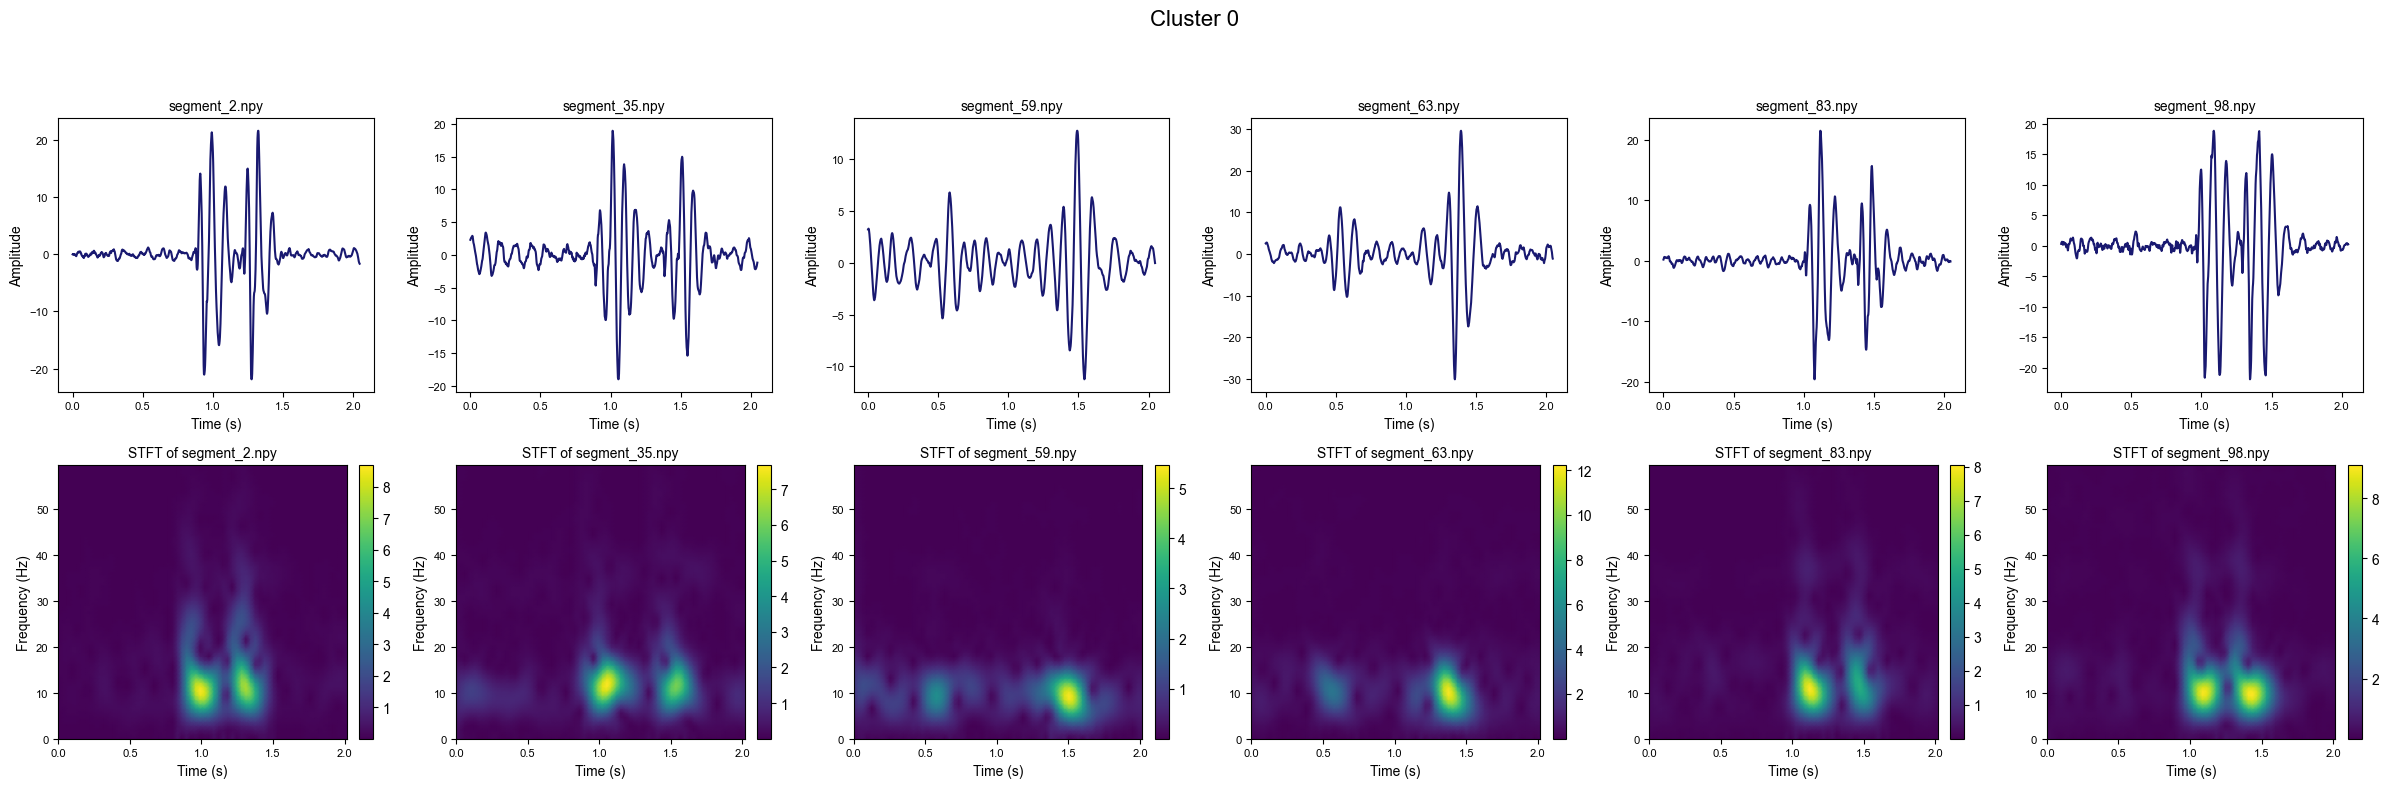

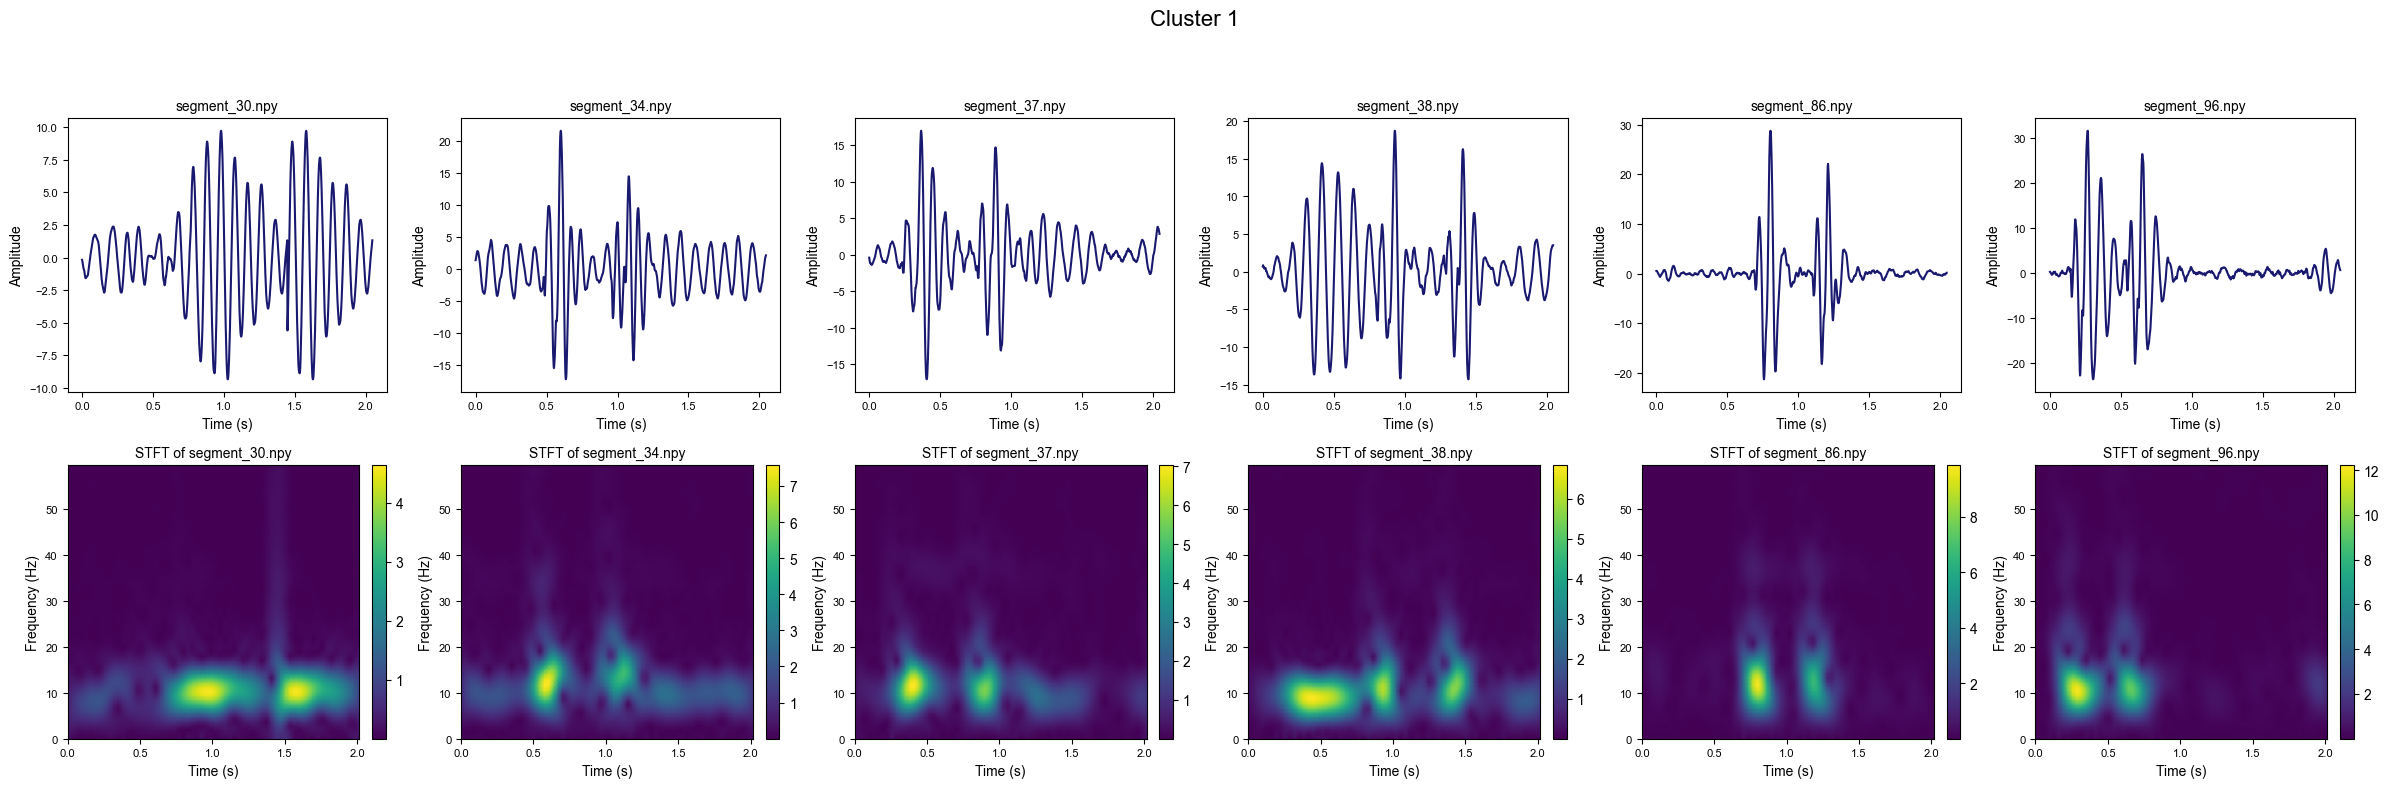

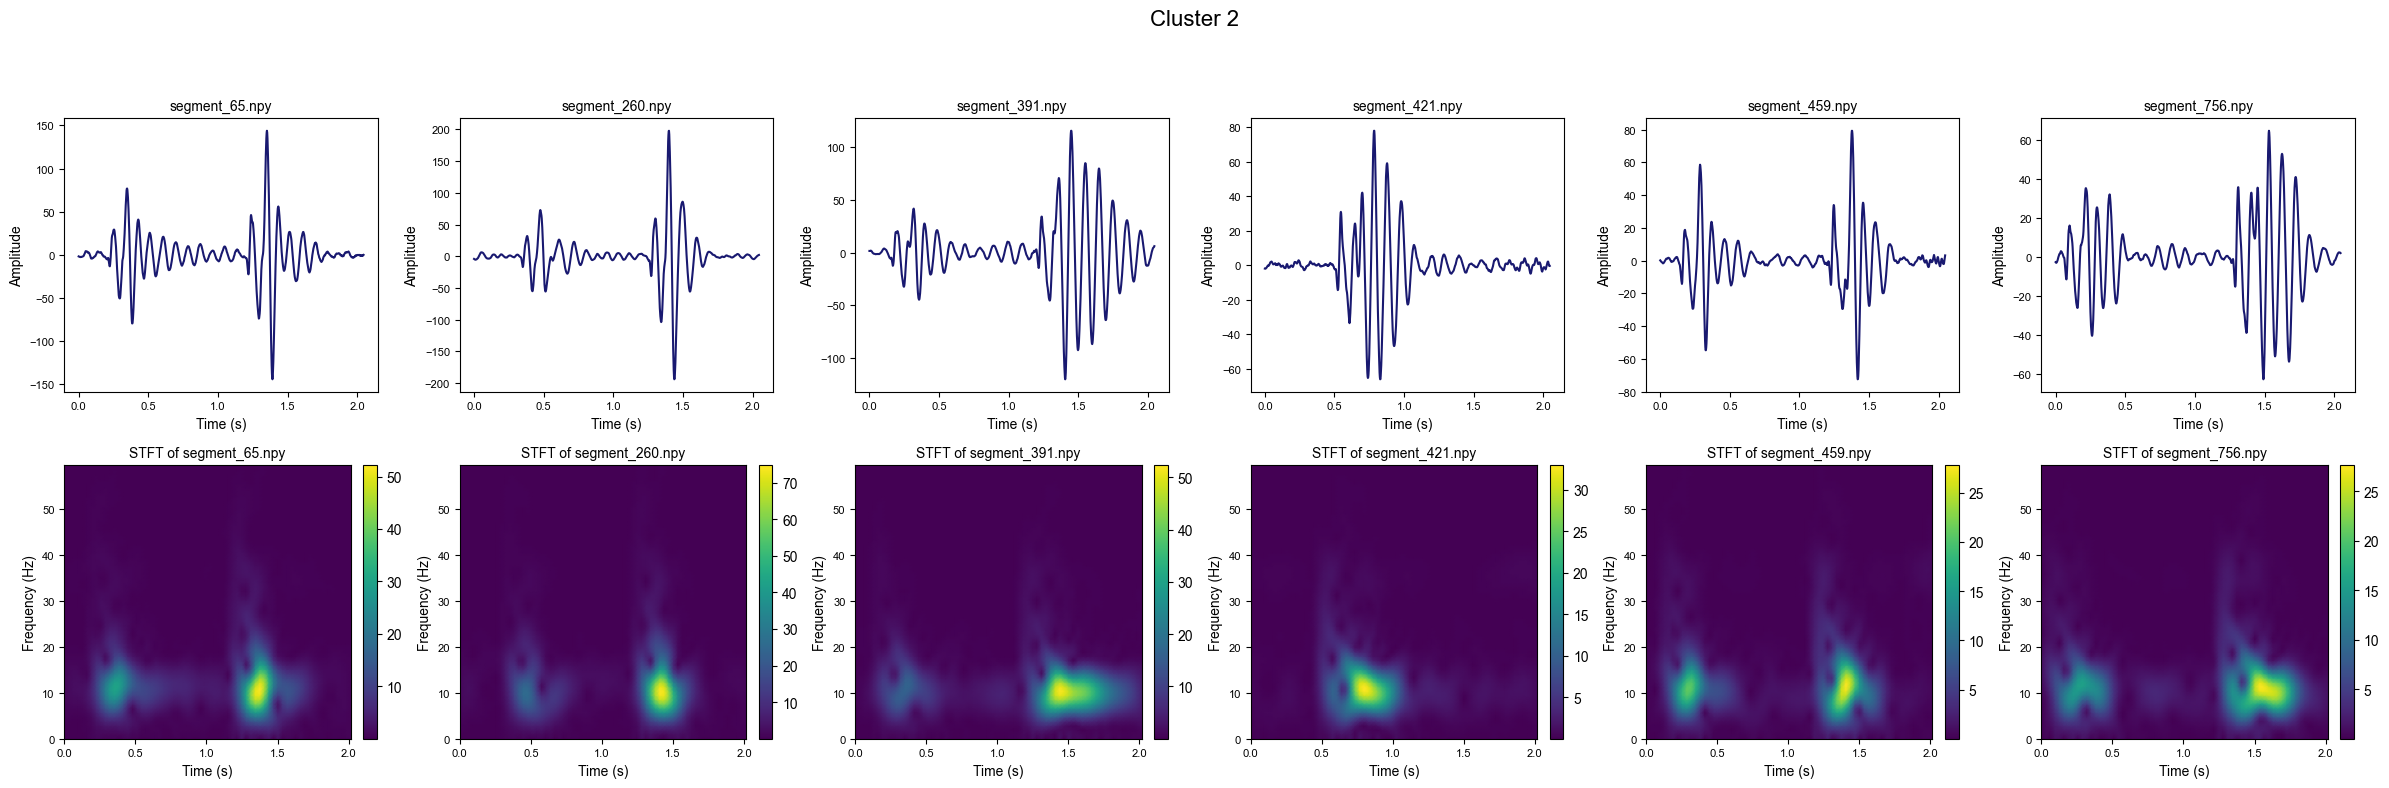

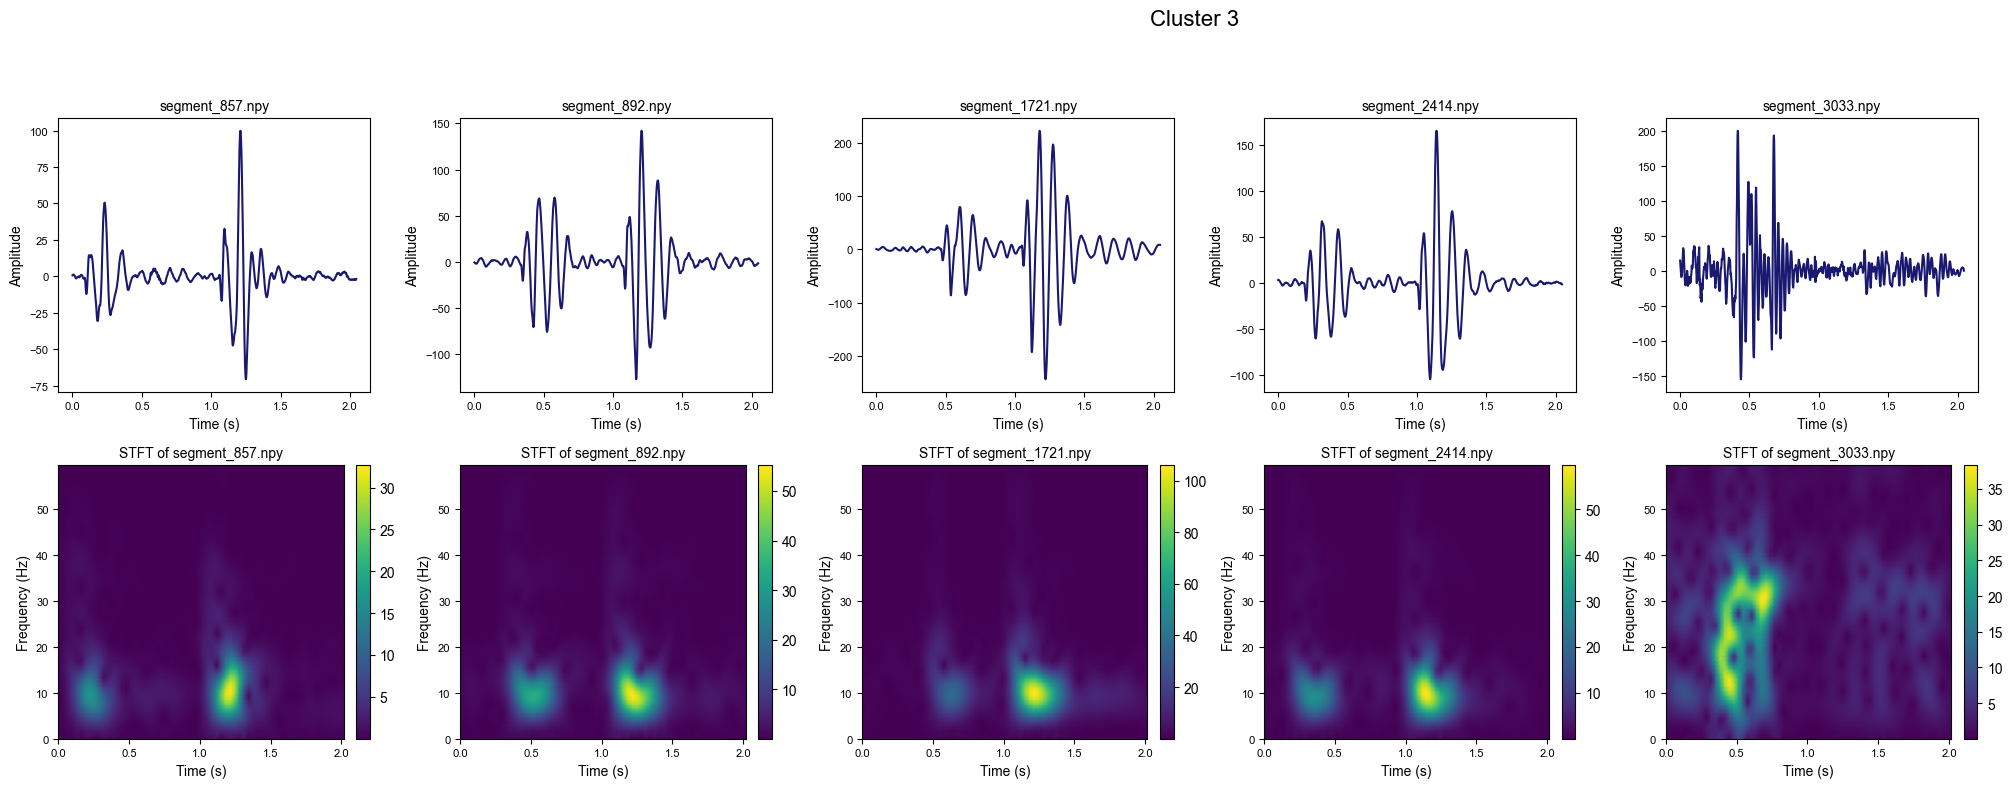

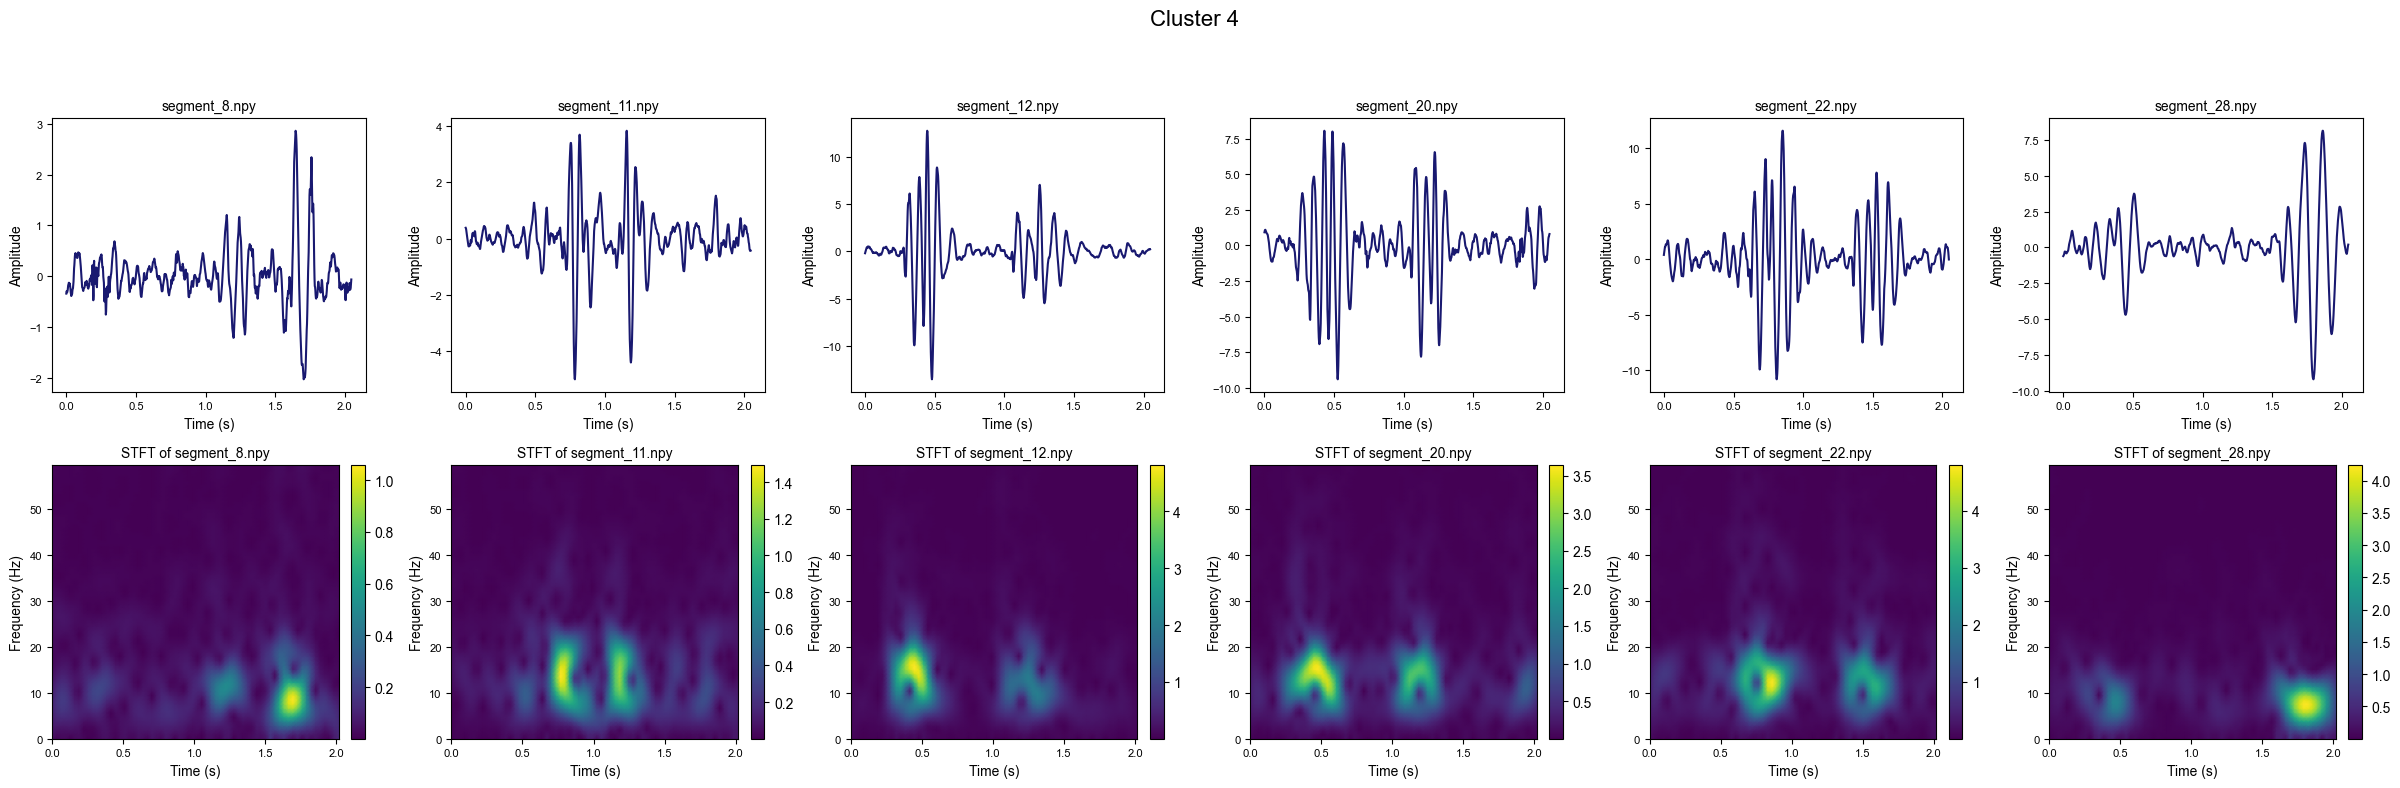

In [34]:
# Show six examples of sample spectrogram assigned to each cluster
# 时间轴
dt = 0.002
signal_length = 2.048  ##切割信号长度
nn = math.floor(signal_length / dt)
time_axis = np.arange(0, nn) * dt

print_all_clusters(x, labels, n_clusters, t, f_valid, x, time_axis)

# t-SNE visualization of clustering results

In [35]:
y = labels

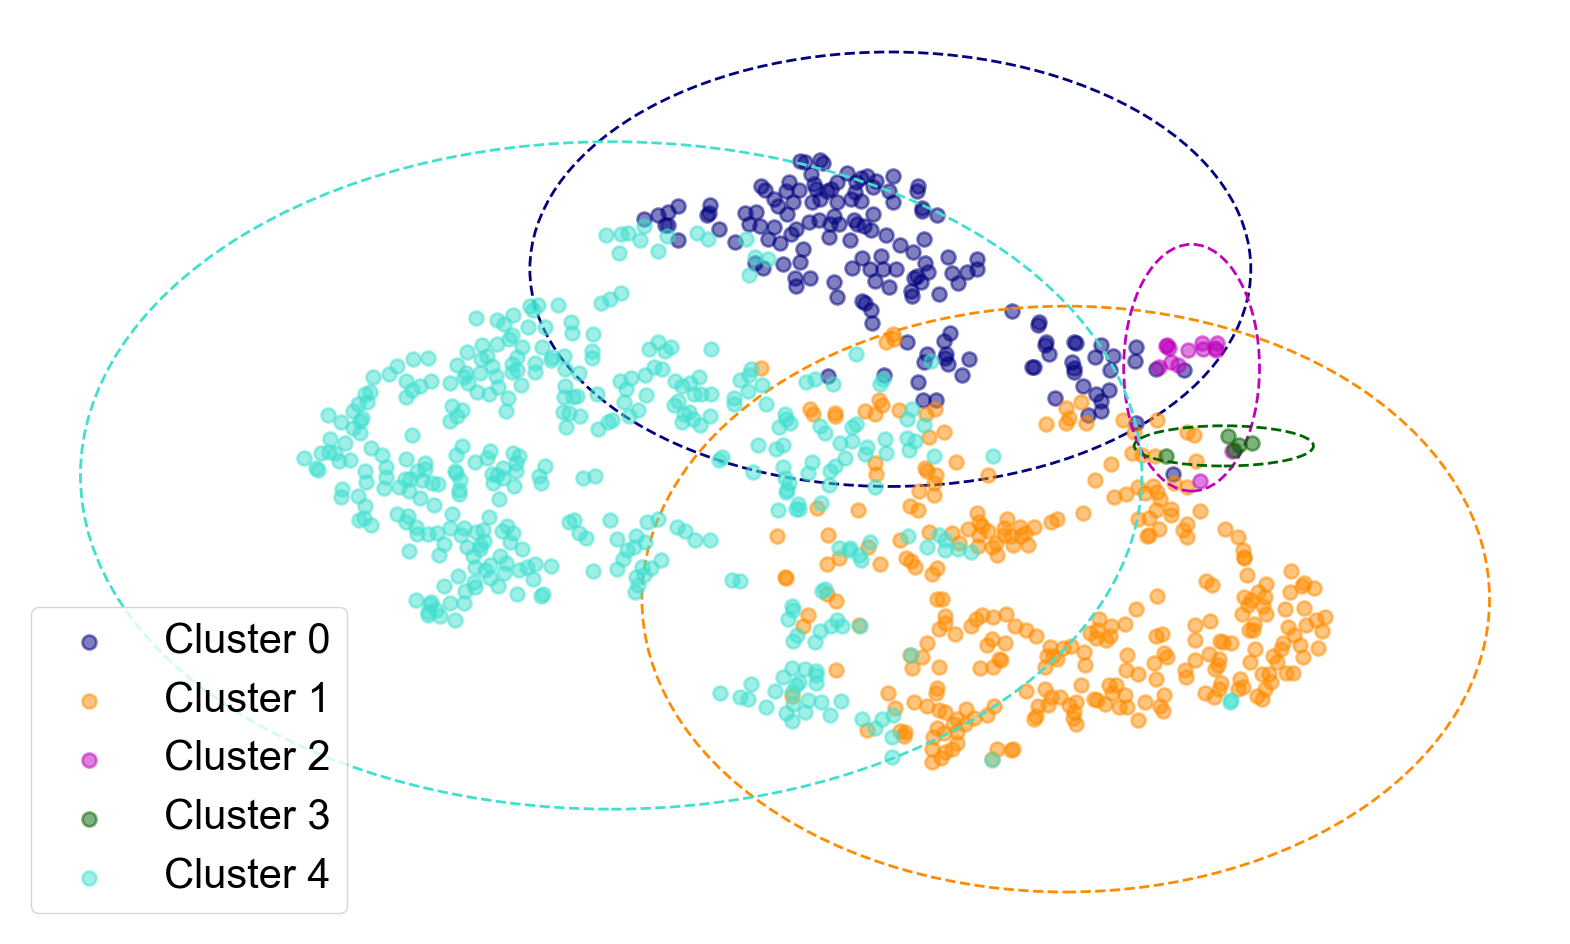

In [36]:
from sklearn.manifold import TSNE
from matplotlib.patches import Ellipse
from sklearn.cluster import KMeans

def plotter(S, labels, target_names, save_path=None):
    """
    Visualize t-SNE 2D embeddings with clustering results.

    Parameters:
    - S: np.ndarray
        2D data after t-SNE dimensionality reduction.
    - labels: np.ndarray
        Cluster assignment for each data point.
    - target_names: list
        List of cluster names.
    - save_path: str, optional
        If provided, saves the figure to this path.
    """
    # Define colors and plot settings
    colors = ['navy', 'darkorange', 'm', 'darkgreen', 'turquoise', 'darkcyan']
    lw = 2
    plt.figure(figsize=(20, 12))
    
    for color, i, target_name in zip(colors, range(len(target_names)), target_names):
        # Select data points belonging to the current cluster
        cluster_data = S[labels == i]
        plt.scatter(cluster_data[:, 0], cluster_data[:, 1],
                    color=color, alpha=0.5, lw=lw, s=100, label=target_name)
        
        # Compute cluster center and standard deviation to draw an ellipse
        center_x, center_y = cluster_data.mean(axis=0)
        width = 2 * cluster_data[:, 0].std()
        height = 2 * cluster_data[:, 1].std()
        ellipse = Ellipse((center_x, center_y), width * 3, height * 3,
                          edgecolor=color, facecolor='none', linestyle='--', linewidth=2)
        plt.gca().add_patch(ellipse)

    # Add legend and remove axes
    plt.legend(loc='lower left', shadow=False, scatterpoints=1, prop={'size': 30})
    # plt.title('t-SNE Visualization of Clusters', fontsize=26)
    plt.axis('off')
    plt.gca().set_frame_on(False)

    # Save figures if paths are provided
    plt.savefig("plot/stft/field data/tsne.png", dpi=300)
    plt.savefig("plot/stft/field data/tsne.pdf", dpi=300)
    plt.show()


# --- Perform t-SNE and visualize clusters ---
# enc = encoder.predict(x)  # Extract high-dimensional features
redu = TSNE(random_state=123).fit_transform(enc)  # Apply t-SNE

# Call the plot function
target_names = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']
plotter(S=redu, labels=labels, target_names=target_names)

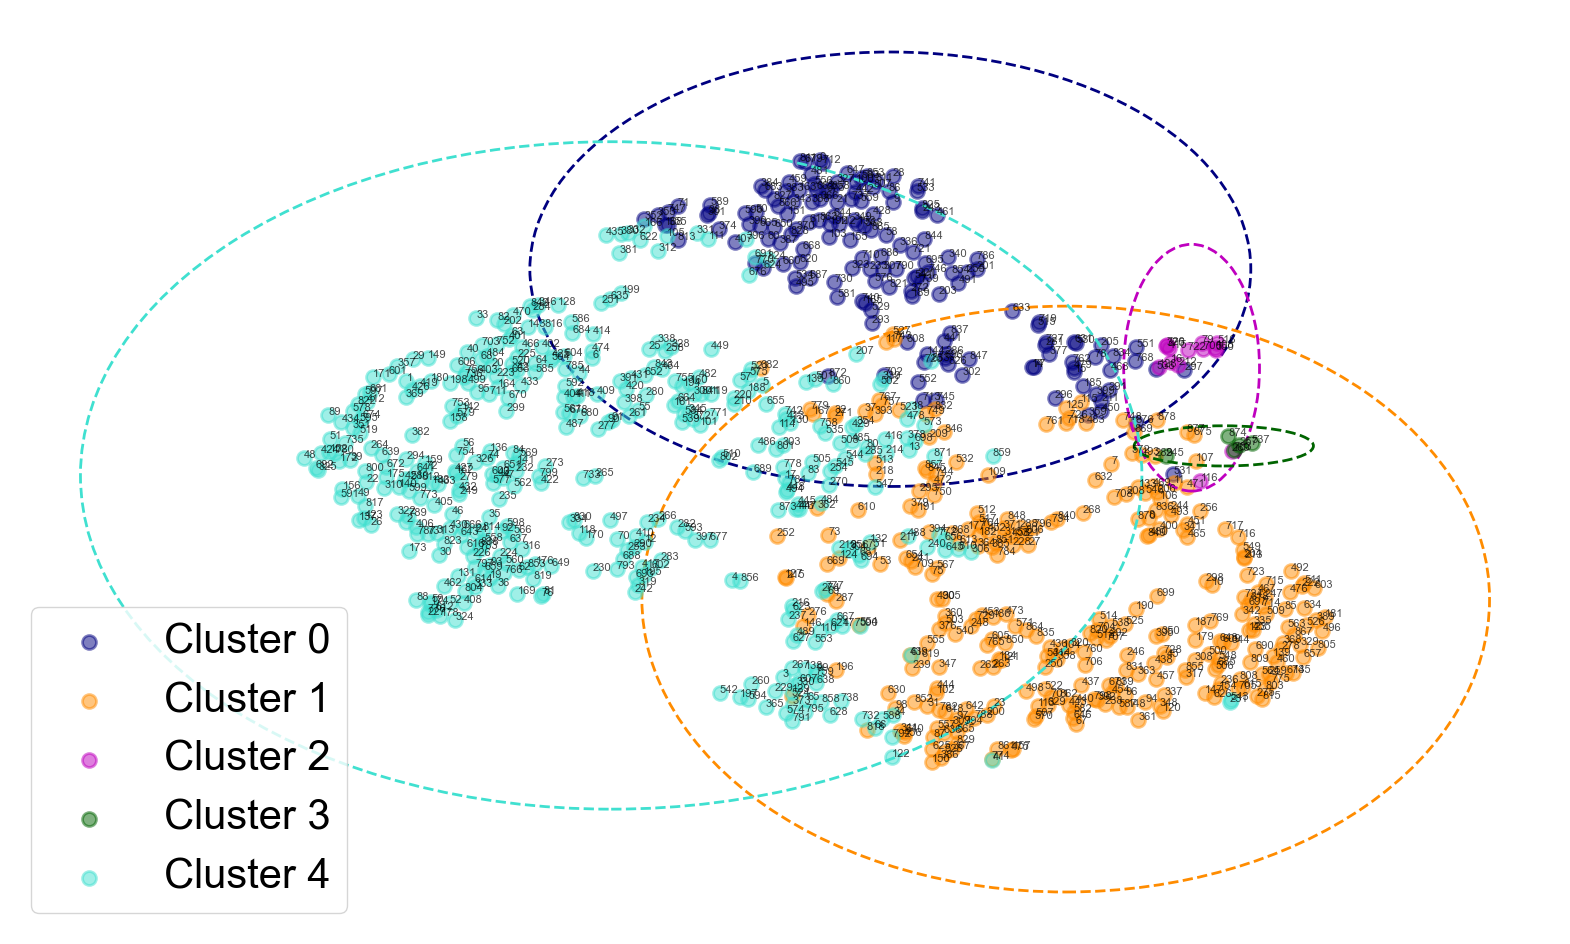

In [37]:
def plotter(S, labels, target_names, save_path=None):
    """
    Visualize t-SNE 2D embeddings with clustering results.

    Parameters:
    - S: np.ndarray
        2D data after t-SNE dimensionality reduction.
    - labels: np.ndarray
        Cluster assignment for each data point.
    - target_names: list
        List of cluster names.
    - save_path: str, optional
        If provided, saves the figure to this path.
    """
    # Define colors and plot settings
    colors = ['navy', 'darkorange', 'm', 'darkgreen', 'turquoise', 'darkcyan']
    lw = 2
    plt.figure(figsize=(20, 12))

    for color, i, target_name in zip(colors, range(len(target_names)), target_names):
        cluster_indices = np.where(labels == i)[0]
        cluster_data = S[cluster_indices]
        
        plt.scatter(cluster_data[:, 0], cluster_data[:, 1],
                    color=color, alpha=0.5, lw=lw, s=100, label=target_name)
        
        # Annotate each point with its index
        for j, point in enumerate(cluster_data):
            idx = cluster_indices[j]
            plt.text(point[0], point[1], str(idx), fontsize=8, alpha=0.7)
        
        # Draw ellipse for cluster spread
        center_x, center_y = cluster_data.mean(axis=0)
        width = 2 * cluster_data[:, 0].std()
        height = 2 * cluster_data[:, 1].std()
        ellipse = Ellipse((center_x, center_y), width * 3, height * 3,
                          edgecolor=color, facecolor='none', linestyle='--', linewidth=2)
        plt.gca().add_patch(ellipse)
    # Add legend and remove axes
    plt.legend(loc='lower left', shadow=False, scatterpoints=1, prop={'size': 30})
    # plt.title('t-SNE Visualization of Clusters', fontsize=26)
    plt.axis('off')
    plt.gca().set_frame_on(False)

    # Save figures if paths are provided
    plt.savefig("plot/stft/field data/tsne_indices.png", dpi=300)
    plt.savefig("plot/stft/field data/tsne_indices.pdf", dpi=300)
    plt.show()


# --- Perform t-SNE and visualize clusters ---
# enc = encoder.predict(x)  # Extract high-dimensional features
redu = TSNE(random_state=123).fit_transform(enc)  # Apply t-SNE

# Call the plot function
target_names = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']
plotter(S=redu, labels=labels, target_names=target_names)